# Setup Paths

In [1]:
import sys
import os

target_folder_name = "SymbolicDensityEstimation"
# 1. Get the current directory of the notebook.
current_dir = os.getcwd()

# # 2. Join it with '..' to get the parent directory.
parent_dir = os.path.join(current_dir, '..')

# # 3. change directory
current_folder_name = os.path.basename(current_dir)
is_match = current_folder_name == target_folder_name
if not is_match:
    os.chdir(parent_dir)

# # Get the current working directory as a string
current_directory = os.getcwd()

print("The current working directory is:")
print(current_directory)

The current working directory is:
/home/angel/WIP/Research/SymbolicDensityEstimation


# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from tqdm import tqdm
from config_management.data_config_dijet import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.stats import multivariate_normal
from scipy.interpolate import RegularGridInterpolator
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import gc
import dill

# Data Exploration

In [3]:
file_path = './data/Dijets.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['mjj', 'HT']
samples = df[columns].to_numpy()
# Extract m13^2 and m23^2 columns
x1 = df["mjj"]
x2 = df["HT"]

        # R         mjj          HT      eta1      eta2      phi1      phi2
0  3.806679  136.146906   83.247403  0.877576  3.027273 -2.840138  0.301454
1  4.415298  275.114546  111.625207  0.581774  3.684234  0.984612 -2.156981
2  3.251374   53.375240   49.012233 -1.133021 -0.295270 -0.018955  3.122637
3  4.691516  165.761831   56.334651  2.688435 -0.795919  0.926908 -2.214684
4  3.451928   67.476058   53.262190  0.491303  1.921758  2.827438 -0.314155


## Scatter Plot

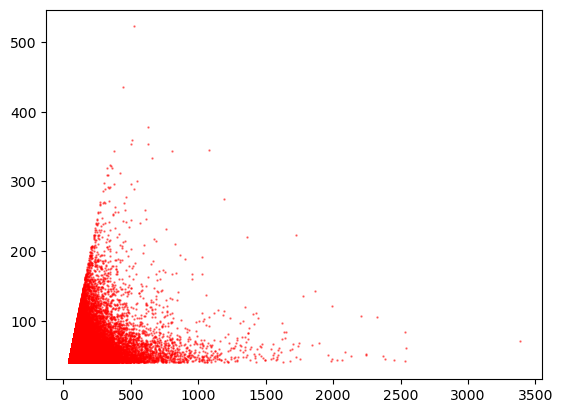

3147

In [4]:
plt.scatter(x1, x2, s=0.5, alpha=0.5, label='Data Points', color='red')
plt.show()
plt.close() 
gc.collect()

In [5]:
if DataConfig.slices is None:
    xmin, xmax = x1.min()-DataConfig.grid_tolerance, x1.max()+DataConfig.grid_tolerance
    ymin, ymax = x2.min()-DataConfig.grid_tolerance, x2.max()+DataConfig.grid_tolerance
    grids = np.mgrid[xmin:xmax:DataConfig.jxbins, ymin:ymax:DataConfig.jxbins]
else:
    slices = DataConfig.slices
    grids = np.mgrid[tuple(slices)]

grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel()])
grid_coordinates = grid_coordinates.T

In [6]:
with open(f"models/dijet_kde_wrapped.pkl", "rb") as f:
    wrapper_model = dill.load(f)
kde_predicted_density = wrapper_model.evaluate(grid_coordinates).reshape(grids[0].shape)

In [7]:
import torch
import normflows as nf

with open(f"models/dijet_neural.pkl", "rb") as f:
    neural_model = dill.load(f)
param = next(neural_model.parameters())
grid_coordinates_tensor = torch.from_numpy(grid_coordinates).to(
    dtype=param.dtype,
    device=param.device
)
print(grid_coordinates_tensor.shape)
batch_size = 5000
neural_density_list = []
neural_model.eval()
with torch.no_grad():
    for batch_id, batch in enumerate(torch.split(grid_coordinates_tensor, batch_size)):
        neural_density_list.append(torch.exp(neural_model.log_prob(batch)))
        print(f"Percentage: {batch_id / len(torch.split(grid_coordinates_tensor, batch_size)) * 100} %")
neural_predicted_density_on_grid_coords = torch.cat(neural_density_list, dim=0).numpy()

neural_predicted_density = neural_predicted_density_on_grid_coords.reshape(grids[0].shape)

torch.Size([9000000, 2])
Percentage: 0.0 %
Percentage: 0.05555555555555555 %
Percentage: 0.1111111111111111 %
Percentage: 0.16666666666666669 %
Percentage: 0.2222222222222222 %
Percentage: 0.2777777777777778 %
Percentage: 0.33333333333333337 %
Percentage: 0.3888888888888889 %
Percentage: 0.4444444444444444 %
Percentage: 0.5 %
Percentage: 0.5555555555555556 %
Percentage: 0.6111111111111112 %
Percentage: 0.6666666666666667 %
Percentage: 0.7222222222222222 %
Percentage: 0.7777777777777778 %
Percentage: 0.8333333333333334 %
Percentage: 0.8888888888888888 %
Percentage: 0.9444444444444444 %
Percentage: 1.0 %
Percentage: 1.0555555555555556 %
Percentage: 1.1111111111111112 %
Percentage: 1.1666666666666667 %
Percentage: 1.2222222222222223 %
Percentage: 1.277777777777778 %
Percentage: 1.3333333333333335 %
Percentage: 1.3888888888888888 %
Percentage: 1.4444444444444444 %
Percentage: 1.5 %
Percentage: 1.5555555555555556 %
Percentage: 1.6111111111111112 %
Percentage: 1.6666666666666667 %
Percentage

In [8]:
neural_predicted_density_unmasked = neural_predicted_density_on_grid_coords
neural_predicted_density_unmasked = neural_predicted_density_unmasked.reshape(grids[0].shape)

In [9]:
mask = np.zeros(grid_coordinates.shape[0], dtype=bool)
reflection_lines = DataConfig.reflection_lines
for i in range(reflection_lines.shape[0]):
    m = reflection_lines[i, 0]  # slope
    b = reflection_lines[i, 1]  # intercept
    gt_or_lt = reflection_lines[i, 2]  # 1 for greater than (valid above), 0 for less than (valid below)
    mask = mask | ((grid_coordinates[:, 1] < m * grid_coordinates[:, 0] + b) if gt_or_lt == 1 else (grid_coordinates[:, 1] > m * grid_coordinates[:, 0] + b))
neural_predicted_density = neural_predicted_density_on_grid_coords
neural_predicted_density[mask] = 0
neural_predicted_density = neural_predicted_density.reshape(grids[0].shape)

## KDE Heatmap

In [10]:
xlims = (-0.1, 1.1)
ylims = (-0.1, 1.1)
color_level_min, color_level_max = 0.0, 0.1

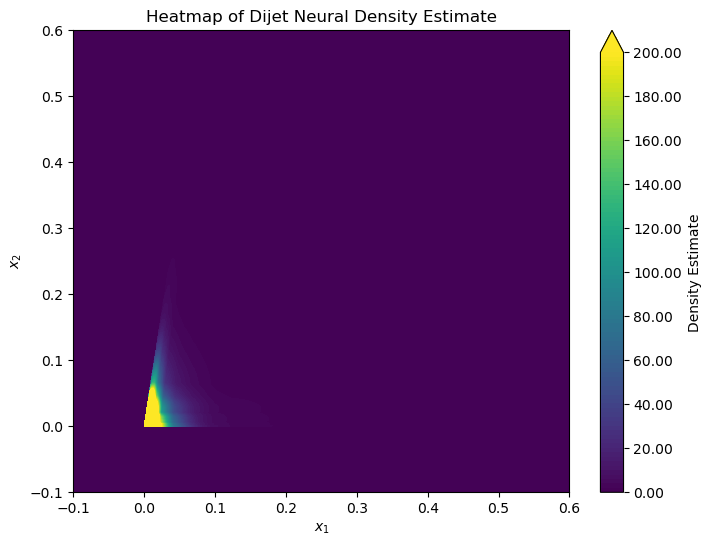

410

In [11]:
levels = np.linspace(color_level_min, 200, 100)  # for 30 intervals

plt.figure(figsize=(8, 6))
cf = plt.contourf(
    grids[0],
    grids[1],
    neural_predicted_density,
    levels=levels,
    cmap="viridis",
    extend="max"
)
cbar = plt.colorbar(cf, format="%.2f", ticks=np.linspace(color_level_min, 200, 11))
cbar.set_label("Density Estimate")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-0.1, 0.6])
plt.ylim([-0.1, 0.6])
plt.title("Heatmap of Dijet Neural Density Estimate")
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

In [12]:
density_scale_factor = np.loadtxt("data/processed_data/dijet_neural_scale_factor.txt")
print(f"scale factor: {density_scale_factor}")
print(f"max neural density: {np.max(neural_predicted_density)}, min neural density: {np.min(neural_predicted_density)}")
neural_predicted_density_scaled = neural_predicted_density * density_scale_factor
print(f"max scaled neural density: {np.max(neural_predicted_density_scaled)}, min scaled neural density: {np.min(neural_predicted_density_scaled)}")
data_in_pipeline = np.loadtxt('data/processed_data/dijet_neural_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
print(f"max data in pipeline: {np.max(data_in_pipeline[:,2])}, min data in pipeline: {np.min(data_in_pipeline[:,2])}")


scale factor: 1.0
max neural density: 1423.8087158203125, min neural density: 0.0
max scaled neural density: 1423.8087158203125, min scaled neural density: 0.0
max data in pipeline: 1423.8203125, min data in pipeline: 1.3525809361425445e-09


# Results

In [13]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [14]:
file_path = "data/pareto_results/dijet_neural_results.py"
exec(open(file_path).read())

Original at complexity 1: 0.6549204390265283
function_ready: 0.6549204390265283
Processed: 0.650000000000000
LaTeX: 0.65

Original at complexity 3: 1.390283836799684 / x1
function_ready: 1.390283836799684 / x1
Processed: 1.4/x1
LaTeX: \frac{1.4}{x_{1}}

Original at complexity 4: pow2(1.182658476738092) / x1
function_ready: pow2(1.182658476738092) / x1
Processed: pow2(1.2)/x1
LaTeX: \frac{1.4}{x_{1}}

Original at complexity 5: (1.6900555744727837 / x1) - 4.181054371907841
function_ready: (1.6900555744727837 / x1) - 4.181054371907841
Processed: -4.2 + 1.7/x1
LaTeX: -4.2 + \frac{1.7}{x_{1}}

Original at complexity 6: 0.0040859250558818155 / pow3(x1 + 0.011968665248315986)
function_ready: 0.0040859250558818155 / pow3(x1 + 0.011968665248315986)
Processed: 0.0041/pow3(x1 + 0.012)
LaTeX: \frac{0.0041}{\left(x_{1} + 0.012\right)^{3}}

Original at complexity 7: pow2(pow3(0.15252001382266905 / (0.045868595755292896 + x1)))
function_ready: pow2(pow3(0.15252001382266905 / (0.045868595755292896 + x

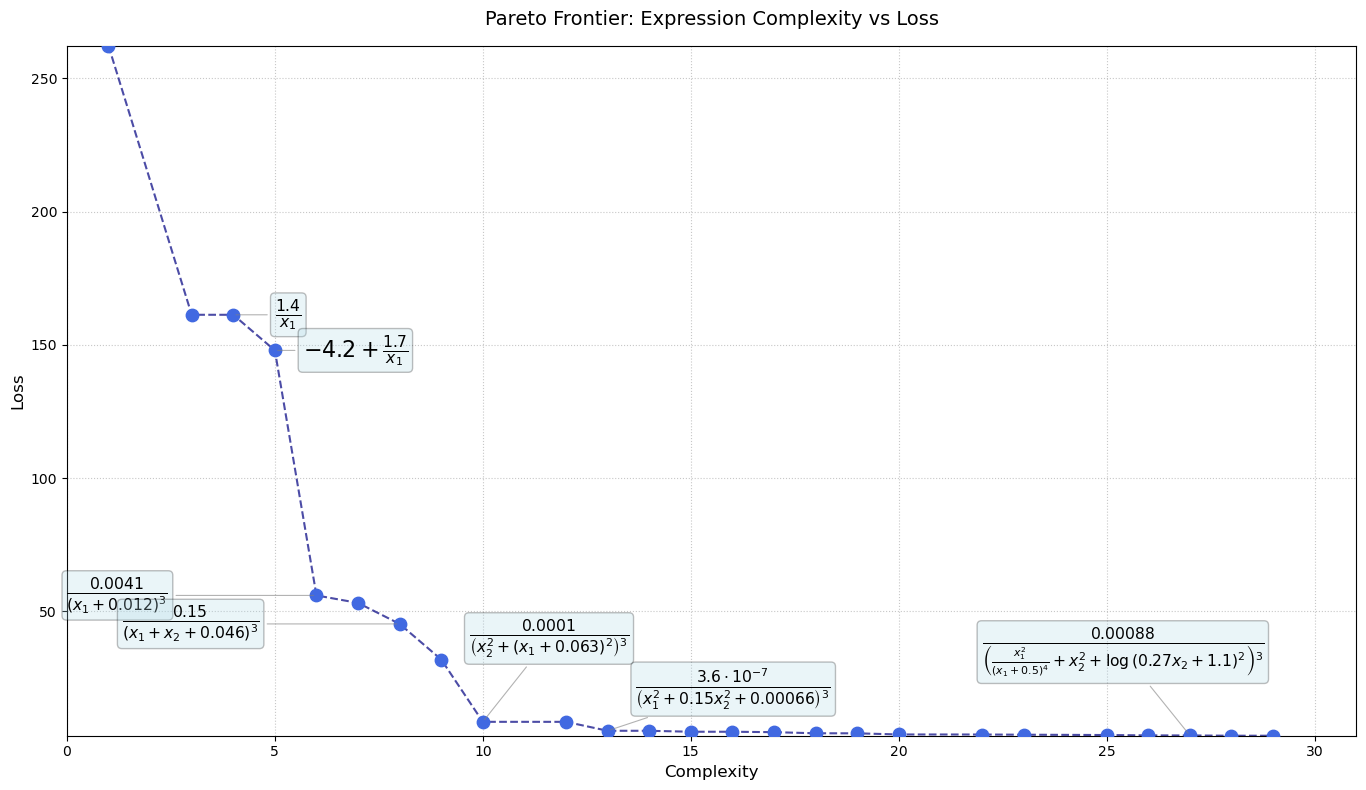

6180

In [15]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2 = sp.symbols('x1 x2')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (30, 0), (20, 0), (-180, 0),
    (-80, 0), (-200, 0), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [3-1, 4-1, 5-1, 7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

# Residuals: Prediction - Ground Truth

In [16]:
level_min = 0
level_max = 200
level_min_delta = -20
level_max_delta = 20

In [17]:
predicted_functions = [eval(f'lambda x1, x2: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]
masked_functions = [
    (lambda f: lambda x1, x2, mask: np.where(mask, 0, f(x1, x2)))(f)
    for f in predicted_functions
]
mask = (grids[1] > 7 * grids[0]) | (grids[1] < 0)

In [18]:
# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    kde_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)

interp_neural_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    neural_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)


# Load the test set for the Gaussian mixture
test_samples = np.loadtxt("./data/processed_data/dijet_test_samples.csv", delimiter=",")

# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(test_samples)
neural_eval_at_samples = interp_neural_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples+1e-12))
likelihood_score_neural = np.sum(np.log(neural_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")
print(f"Likelihood score of the neural spline: {likelihood_score_neural:,}")

Likelihood score of the corrected KDE: 47,225.762148995906
Likelihood score of the neural spline: 54,288.89702938321


Likelihood score of the corrected KDE: 47,225.76214899293

Function at complexity 1: Likelihood score = -0.42324151785815944
Function at complexity 3: Likelihood score = 49,490.24863743922
Function at complexity 4: Likelihood score = 49,550.46639885573
Function at complexity 5: Likelihood score = nan
Function at complexity 6: Likelihood score = 54,727.242117760616
Function at complexity 7: Likelihood score = 53,794.058395238535
Function at complexity 8: Likelihood score = 55,150.15976742658
Function at complexity 9: Likelihood score = 55,865.838432911536
Function at complexity 10: Likelihood score = 54,894.274977372086
Function at complexity 12: Likelihood score = 54,924.51189030383
Function at complexity 13: Likelihood score = 51,942.32823333795
Function at complexity 14: Likelihood score = 51,914.925607059675
Function at complexity 15: Likelihood score = 53,056.36544987257
Function at complexity 16: Likelihood score = 53,038.526096402355
Function at complexity 17: Likelihood score = 

/tmp/ipykernel_488978/1837437248.py:9: RuntimeWarning: invalid value encountered in log
  likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)


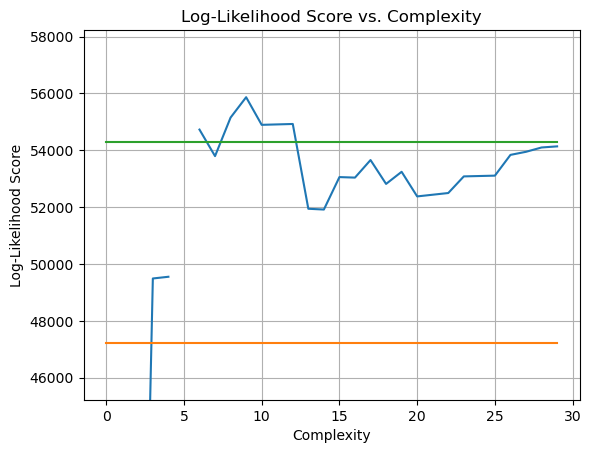

In [20]:
kde_eval_at_samples = interp_kde_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples+1e-130))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}\n")

log_likelihood_scores = []
for idx, func in enumerate(predicted_functions):
    # Compute likelihood scores
    prediction_eval_at_samples = func(test_samples[:, 0], test_samples[:, 1])
    likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)
    log_likelihood_scores.append(likelihood_score_pred)
    print(f"Function at complexity {complexity[idx]}: Likelihood score = {likelihood_score_pred:,}")

plt.plot(complexity, log_likelihood_scores)
plt.plot([0, max(complexity)], [likelihood_score, likelihood_score])
plt.plot([0, max(complexity)], [likelihood_score_neural, likelihood_score_neural])
plt.xlabel("Complexity")
plt.ylabel("Log-Likelihood Score")
plt.title("Log-Likelihood Score vs. Complexity")
plt.ylim([likelihood_score-2000, likelihood_score+11000])
plt.grid(True)
plt.show()

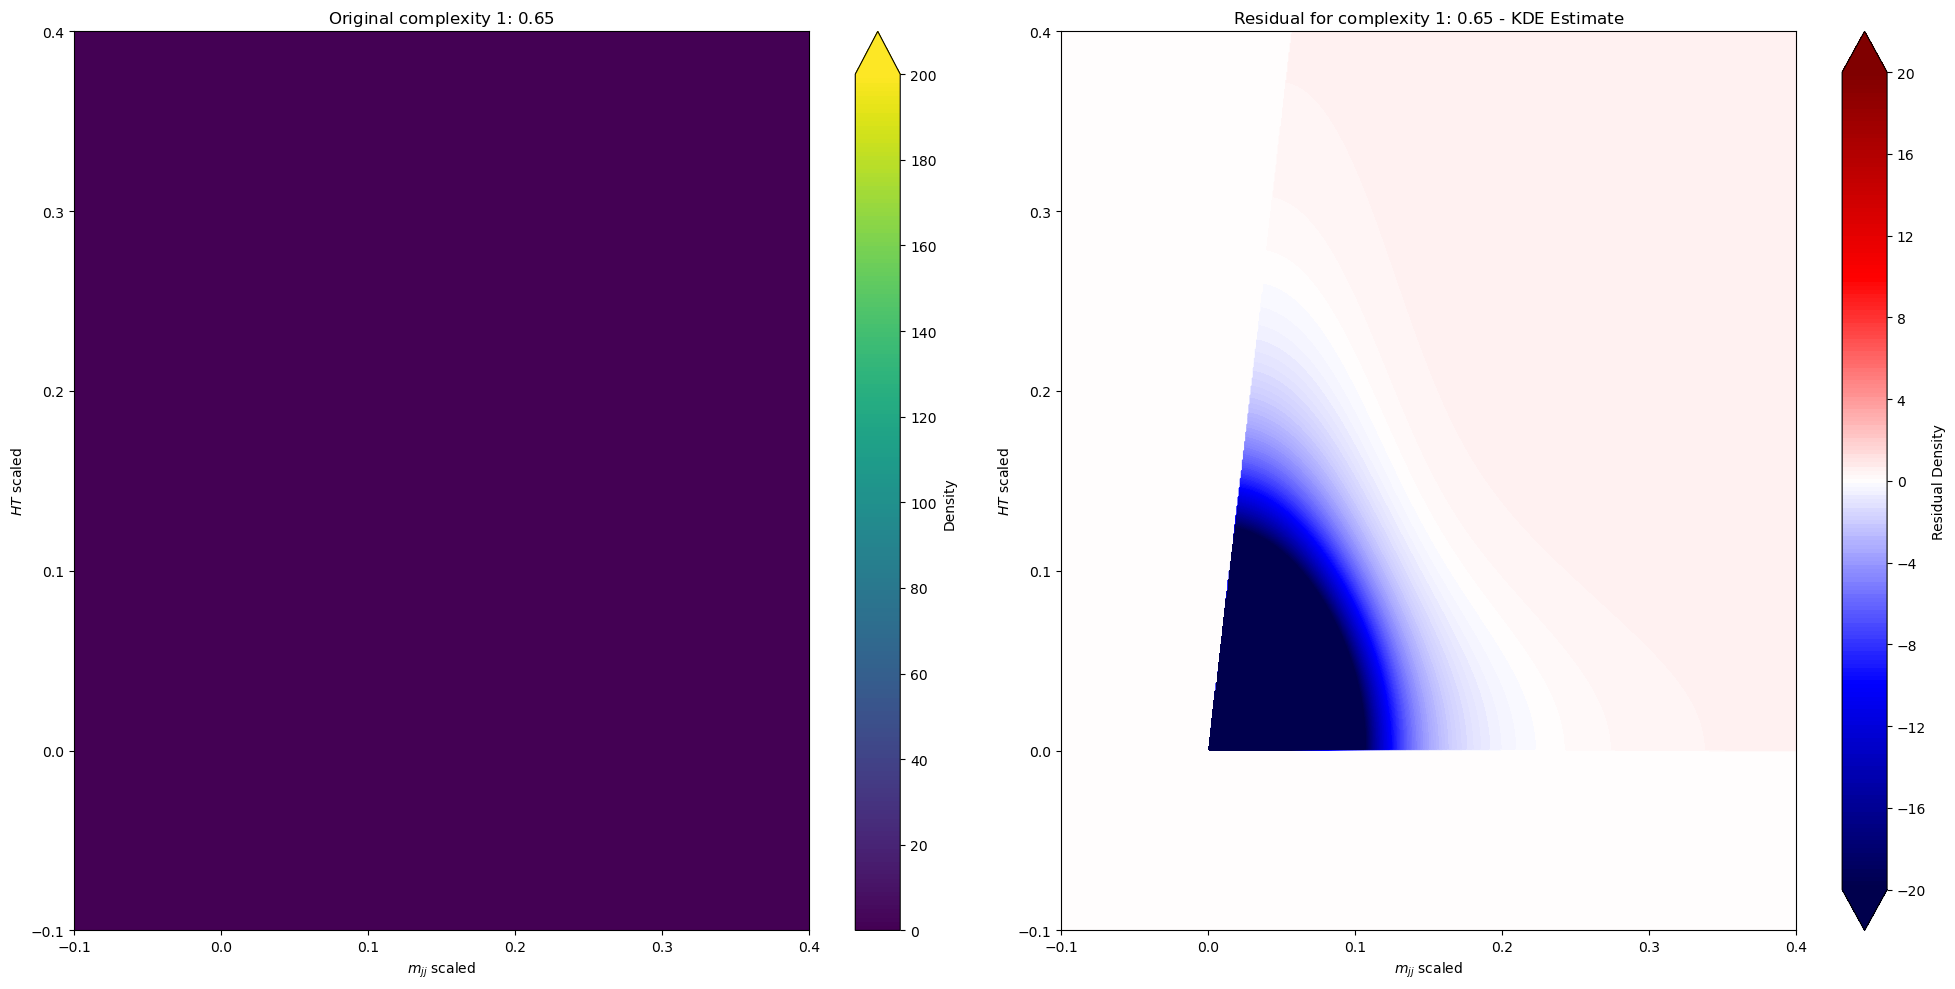

Complexity 1: Likelihood score: -4,232.415178596864
complexity 1 :: min predict: 0.00, max predict: 0.65
complexity 1 :: min residual: -182.22, max residual: 0.65
Complexity 1: MSE error: 1.589765e+01


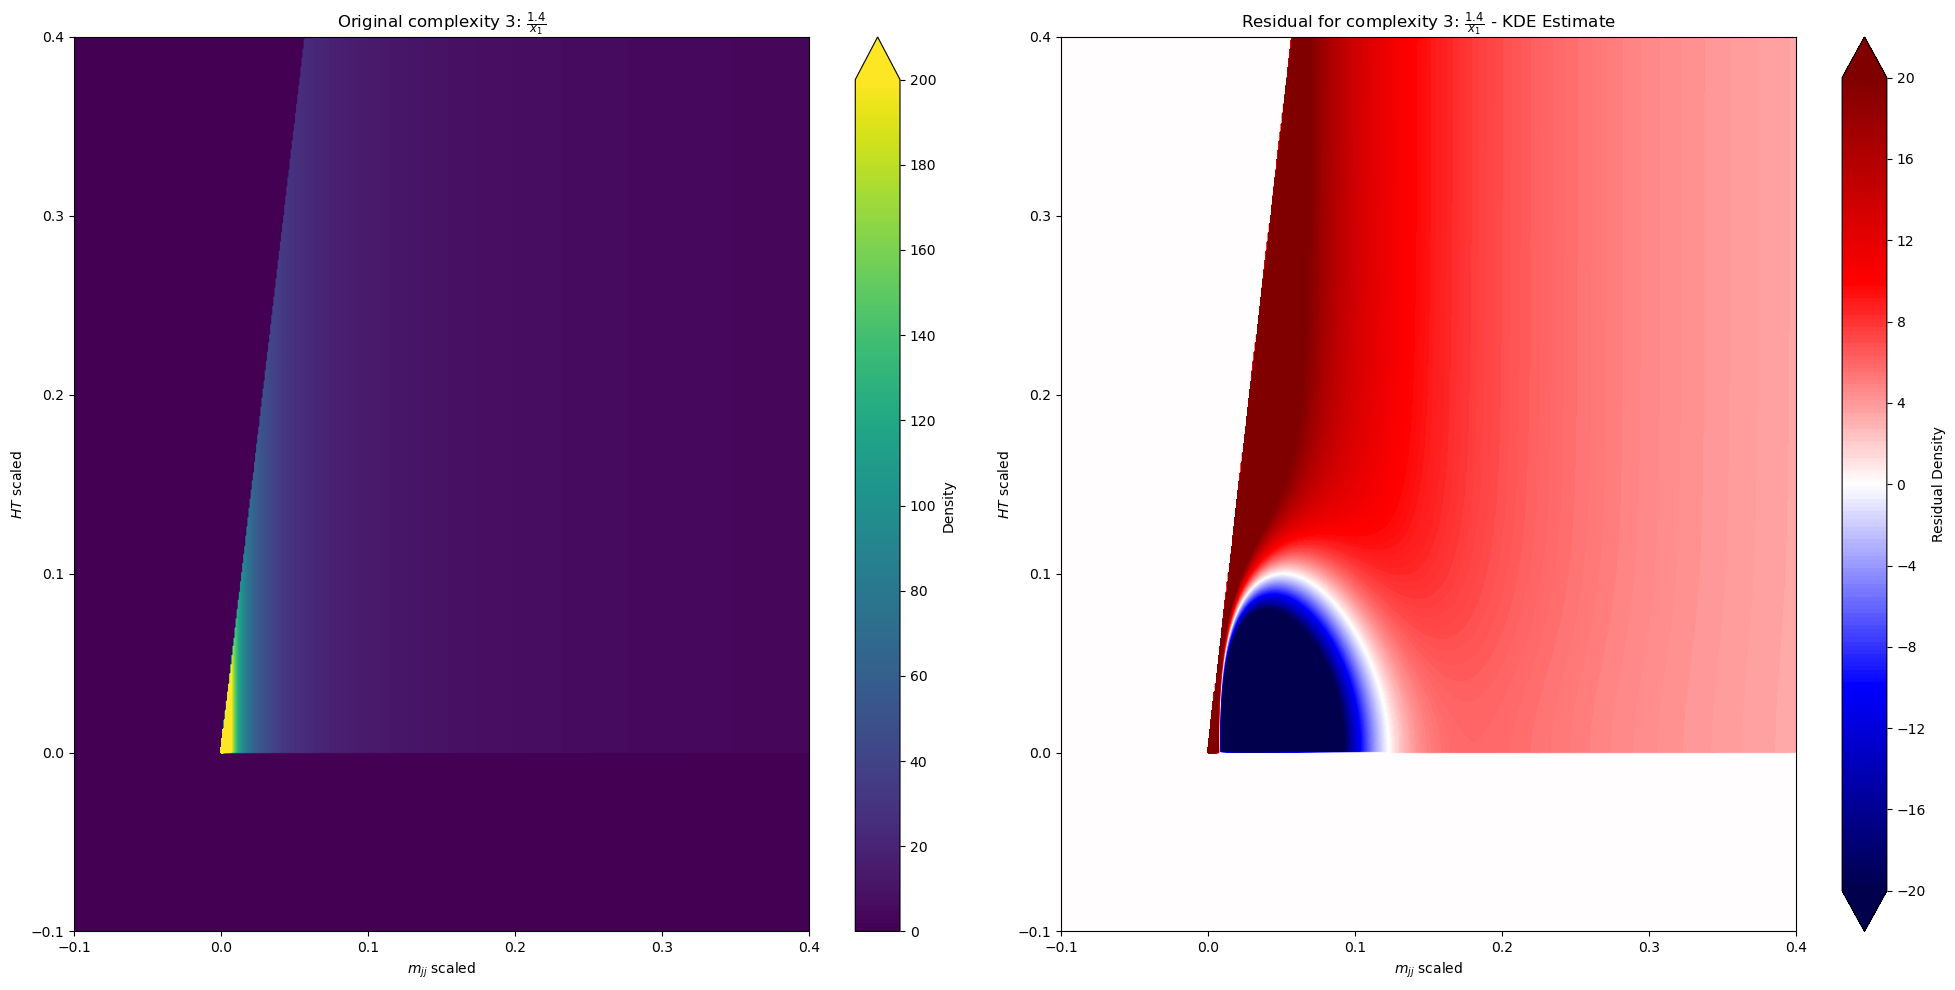

Complexity 3: Likelihood score: 49,490.24863743907
complexity 3 :: min predict: 0.00, max predict: 3790.42
complexity 3 :: min residual: -113.50, max residual: 3611.22
Complexity 3: MSE error: 1.932789e+01


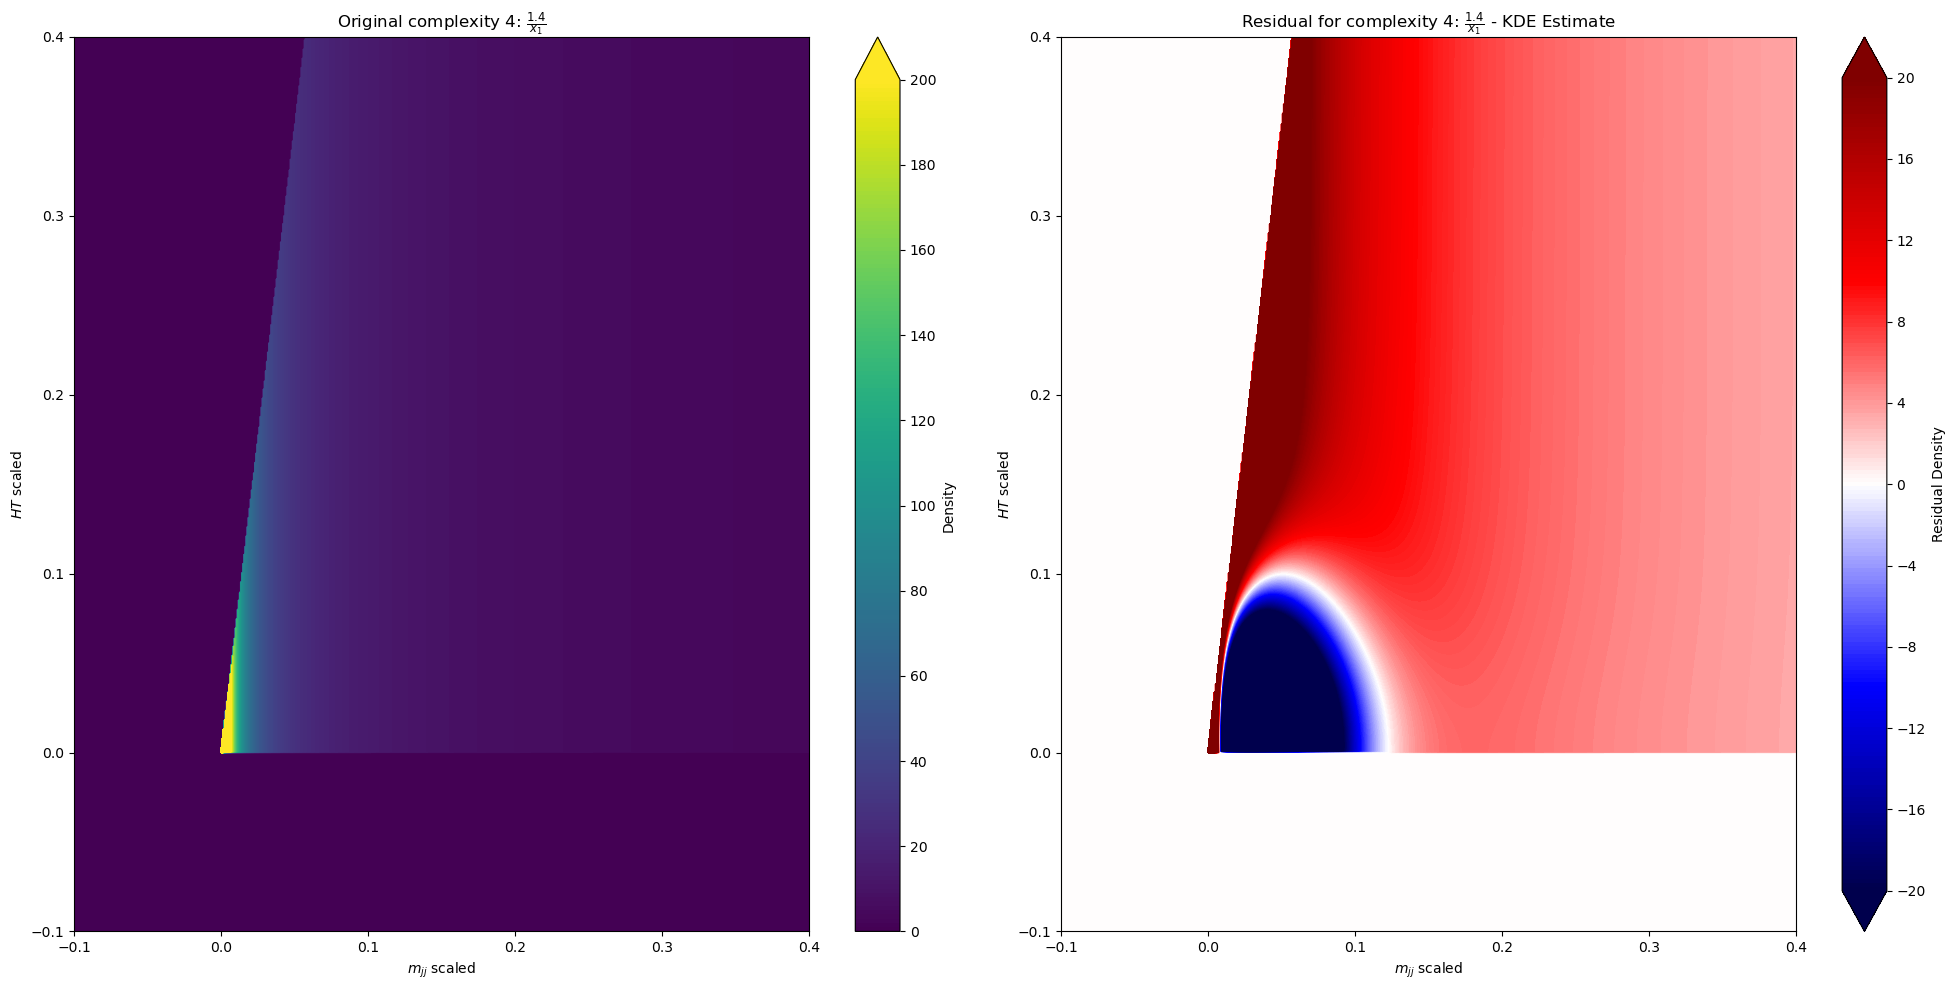

Complexity 4: Likelihood score: 49,550.46639885558
complexity 4 :: min predict: 0.00, max predict: 3813.31
complexity 4 :: min residual: -113.21, max residual: 3634.11
Complexity 4: MSE error: 1.949272e+01


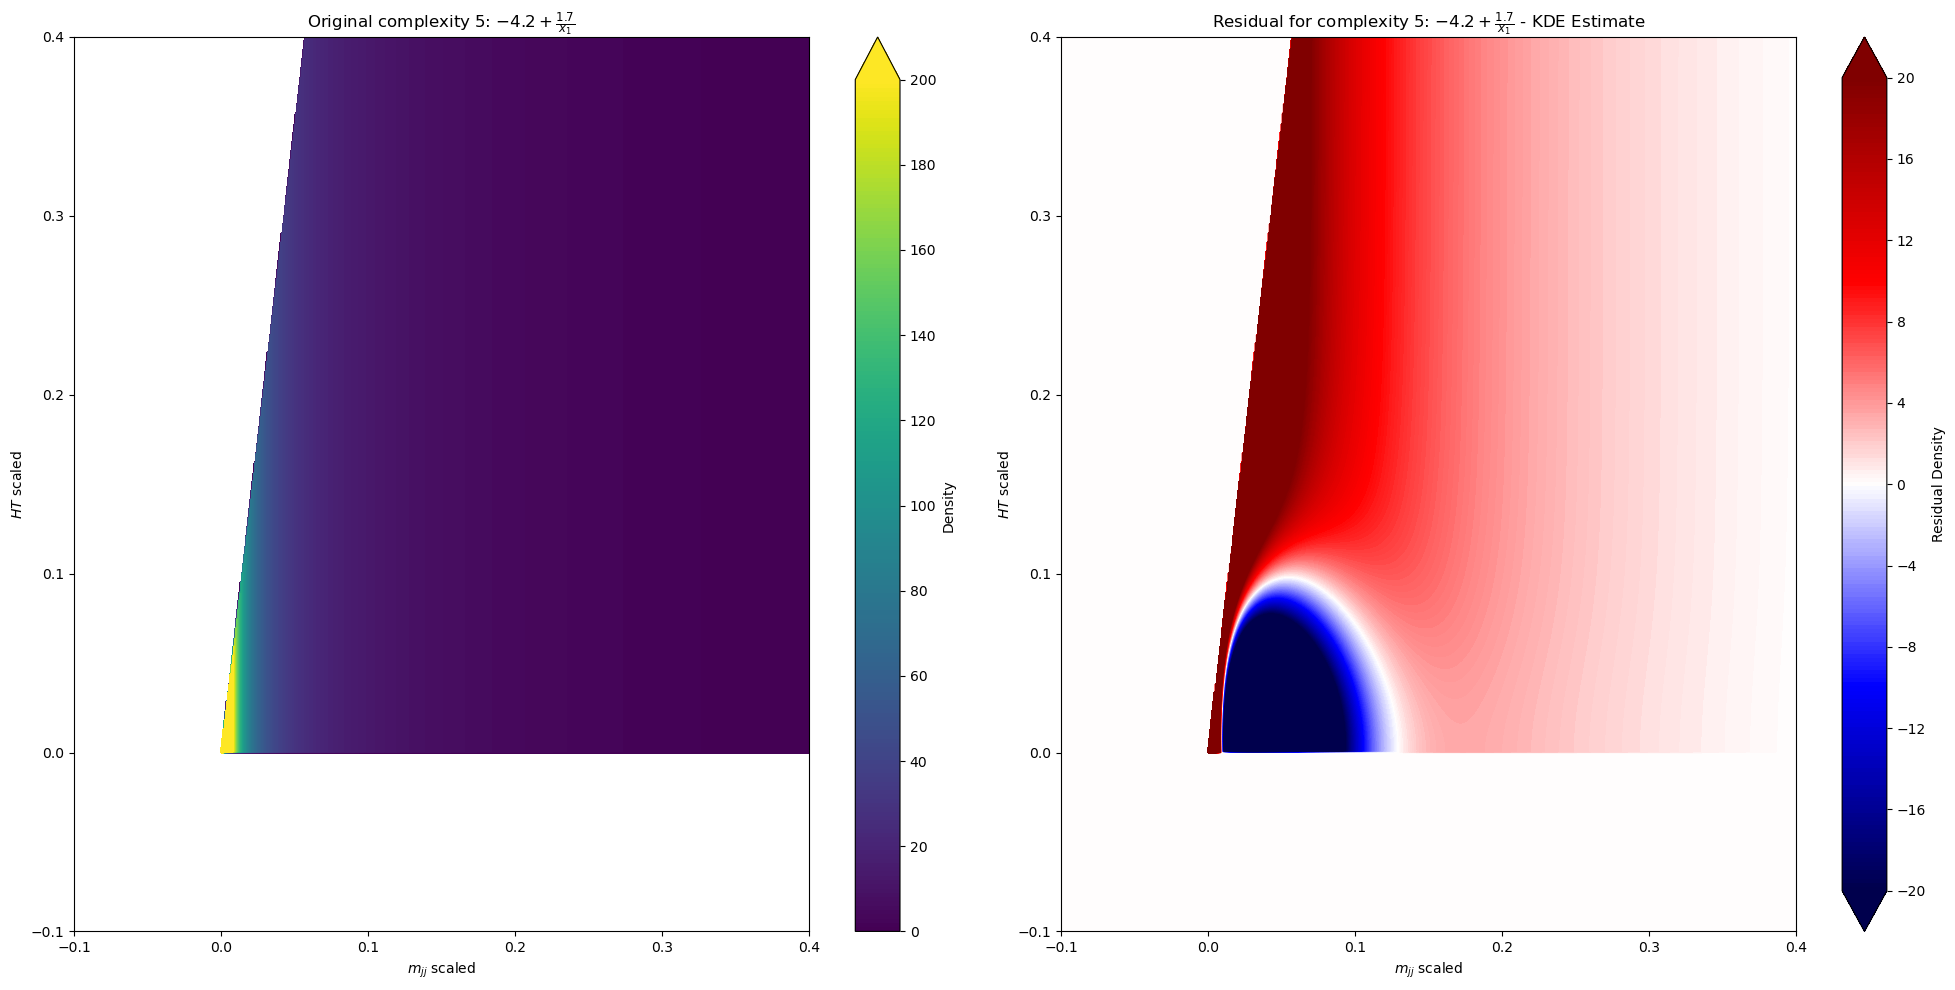

/tmp/ipykernel_488978/2338351544.py:73: RuntimeWarning: invalid value encountered in log
  likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))


Complexity 5: Likelihood score: nan
complexity 5 :: min predict: -2.64, max predict: 4603.53
complexity 5 :: min residual: -107.55, max residual: 4424.33
Complexity 5: MSE error: 2.234326e+01


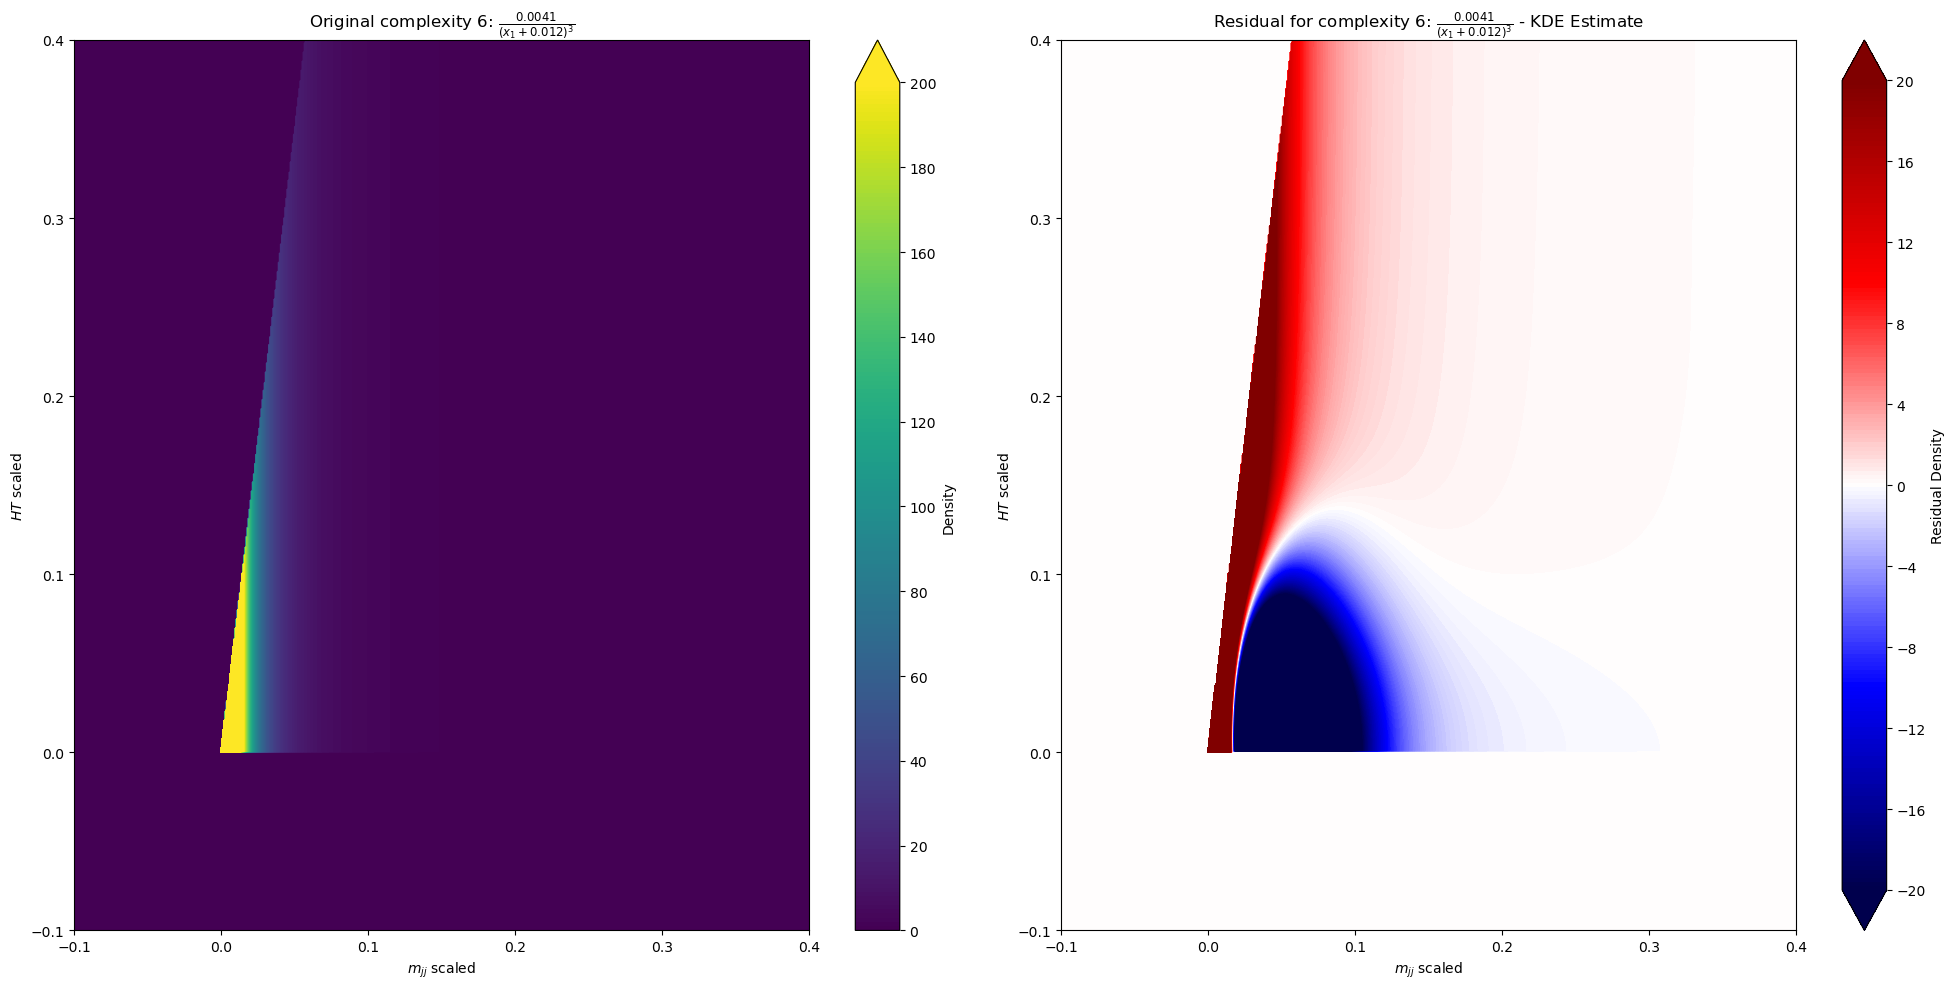

Complexity 6: Likelihood score: 54,727.24211775976
complexity 6 :: min predict: 0.00, max predict: 2176.83
complexity 6 :: min residual: -111.26, max residual: 1997.63
Complexity 6: MSE error: 3.882674e+01


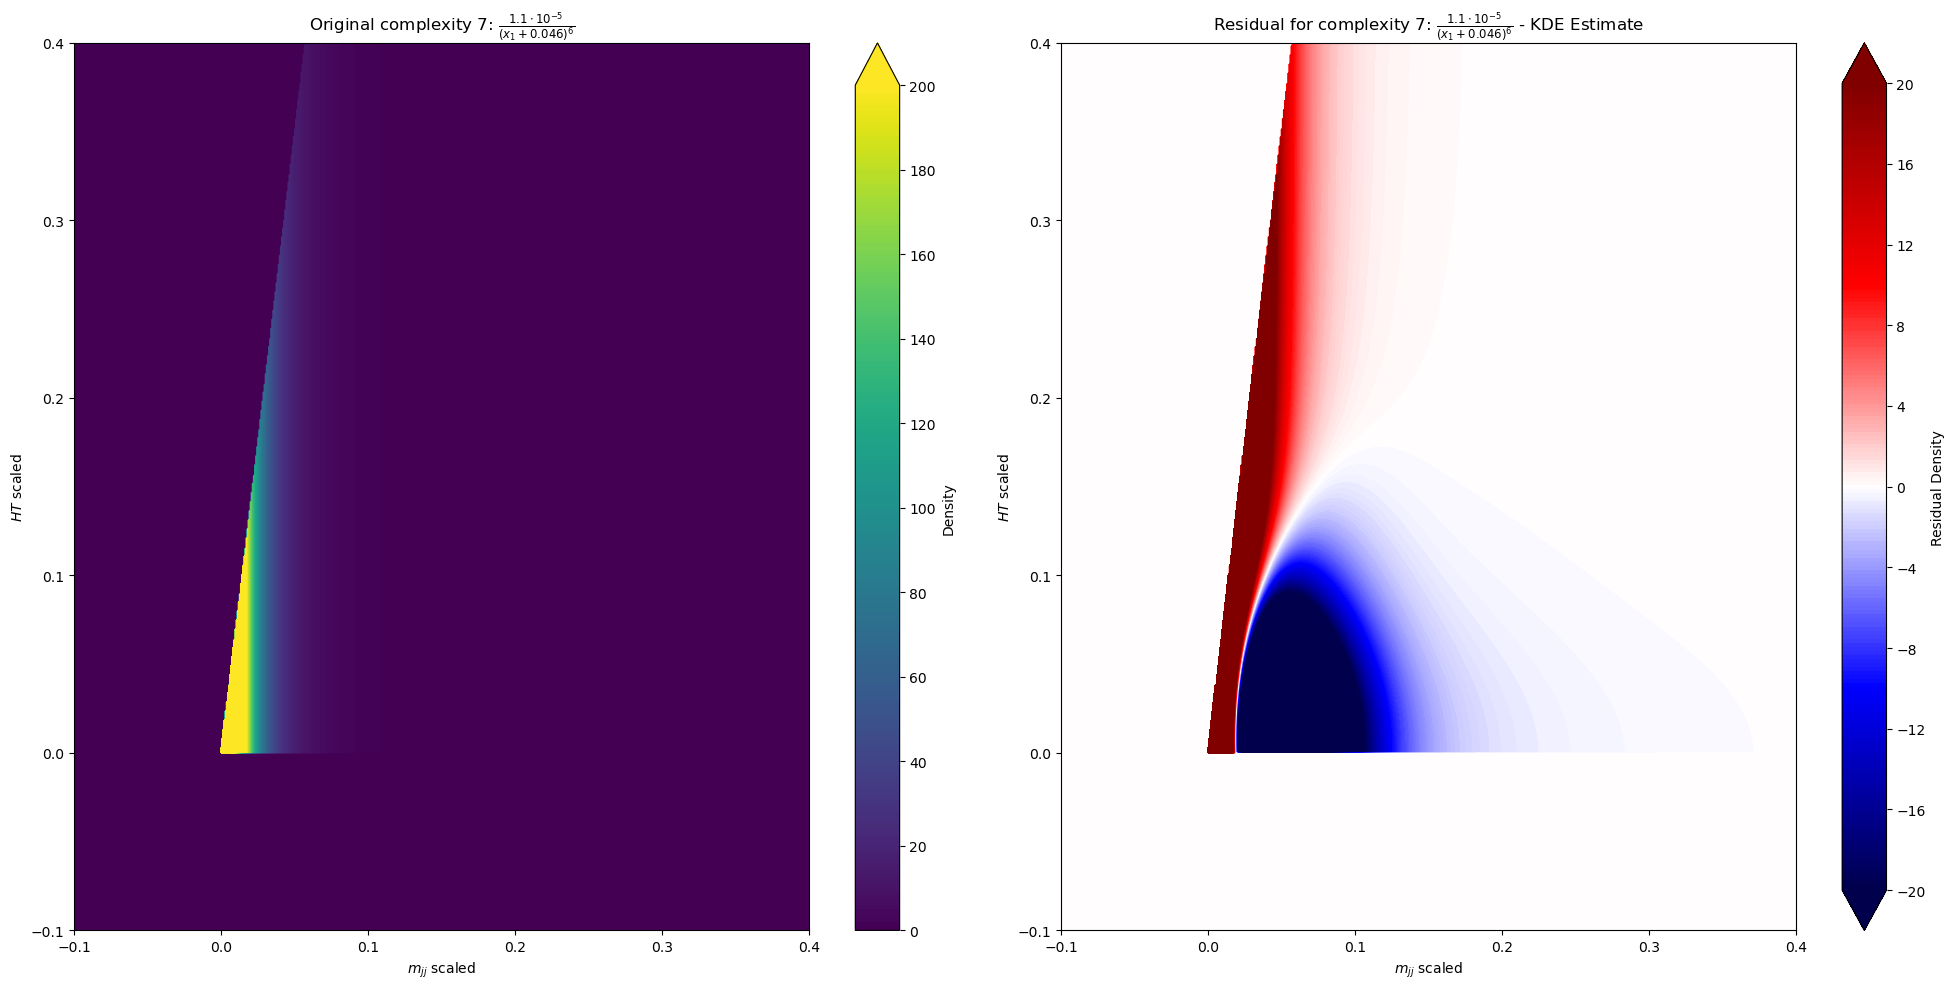

Complexity 7: Likelihood score: 53,794.05839520192
complexity 7 :: min predict: 0.00, max predict: 1288.59
complexity 7 :: min residual: -108.24, max residual: 1109.39
Complexity 7: MSE error: 2.926703e+01


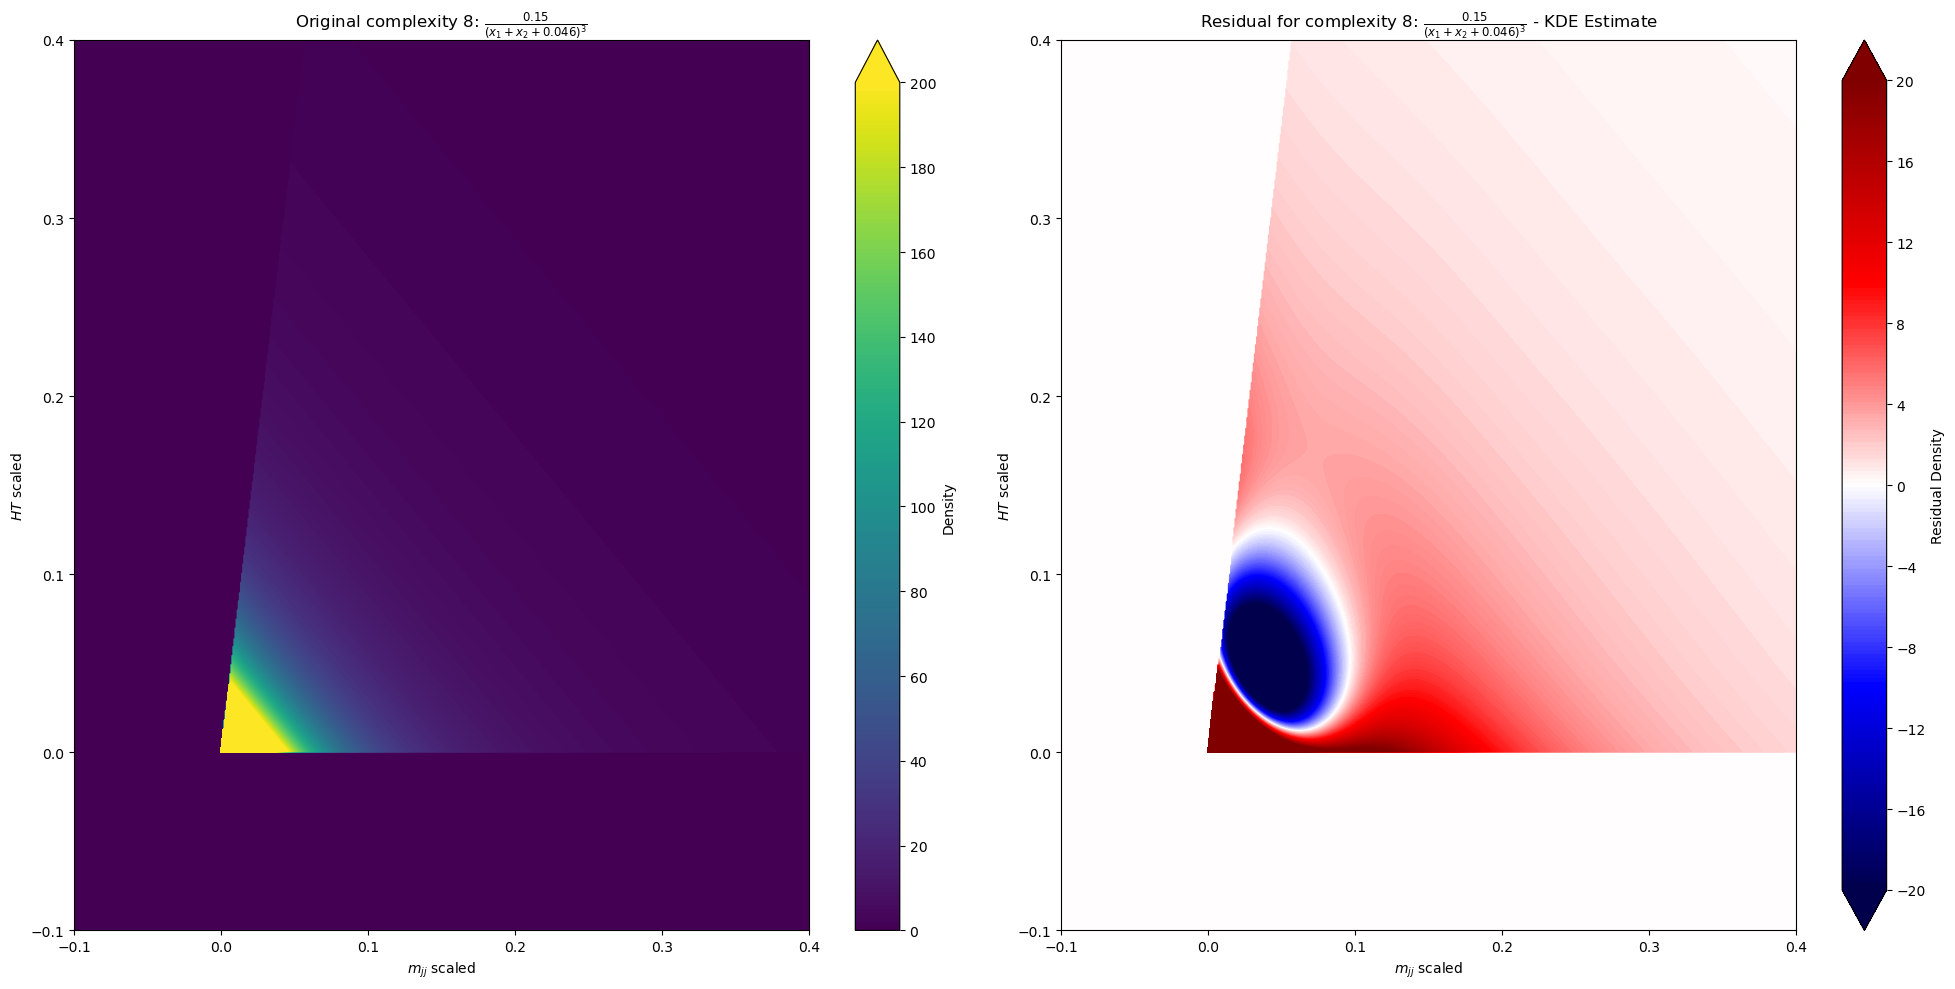

Complexity 8: Likelihood score: 55,150.15976742642
complexity 8 :: min predict: 0.00, max predict: 1506.98
complexity 8 :: min residual: -39.25, max residual: 1327.78
Complexity 8: MSE error: 1.907746e+01


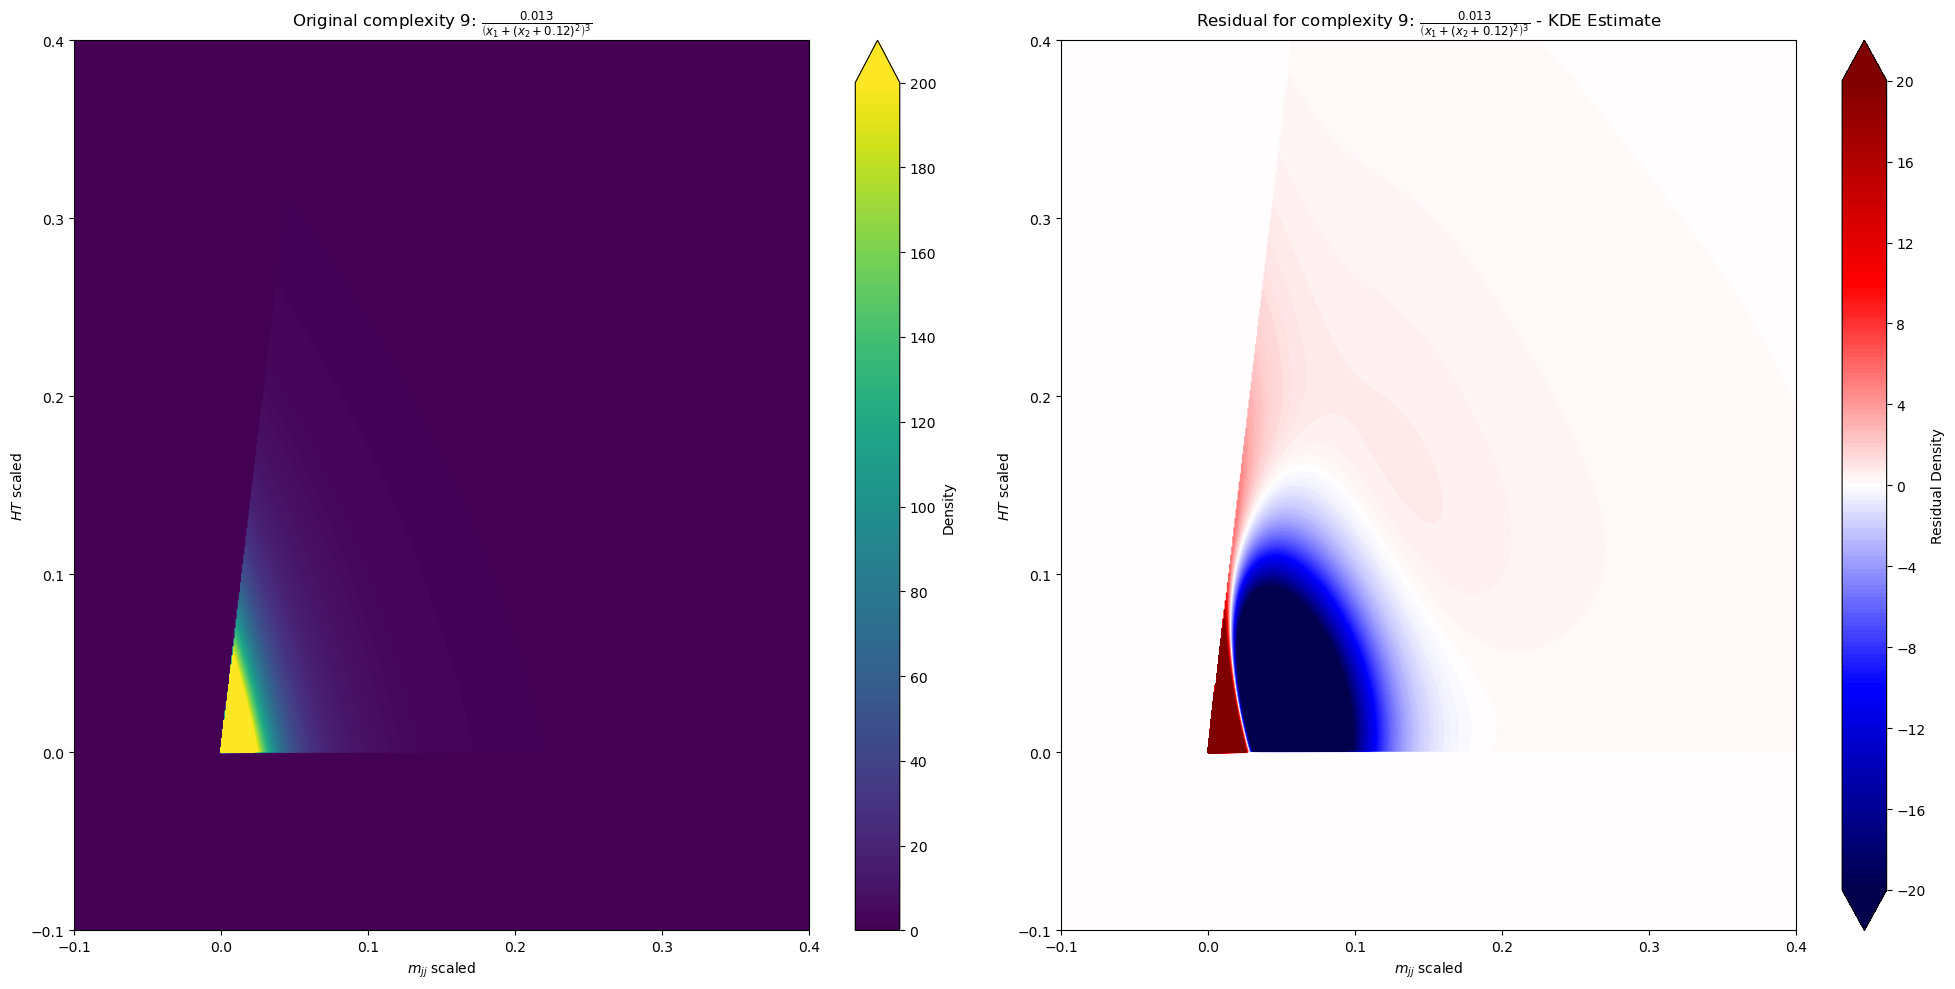

Complexity 9: Likelihood score: 55,865.83843291105
complexity 9 :: min predict: 0.00, max predict: 3253.54
complexity 9 :: min residual: -78.38, max residual: 3074.34
Complexity 9: MSE error: 5.078393e+01


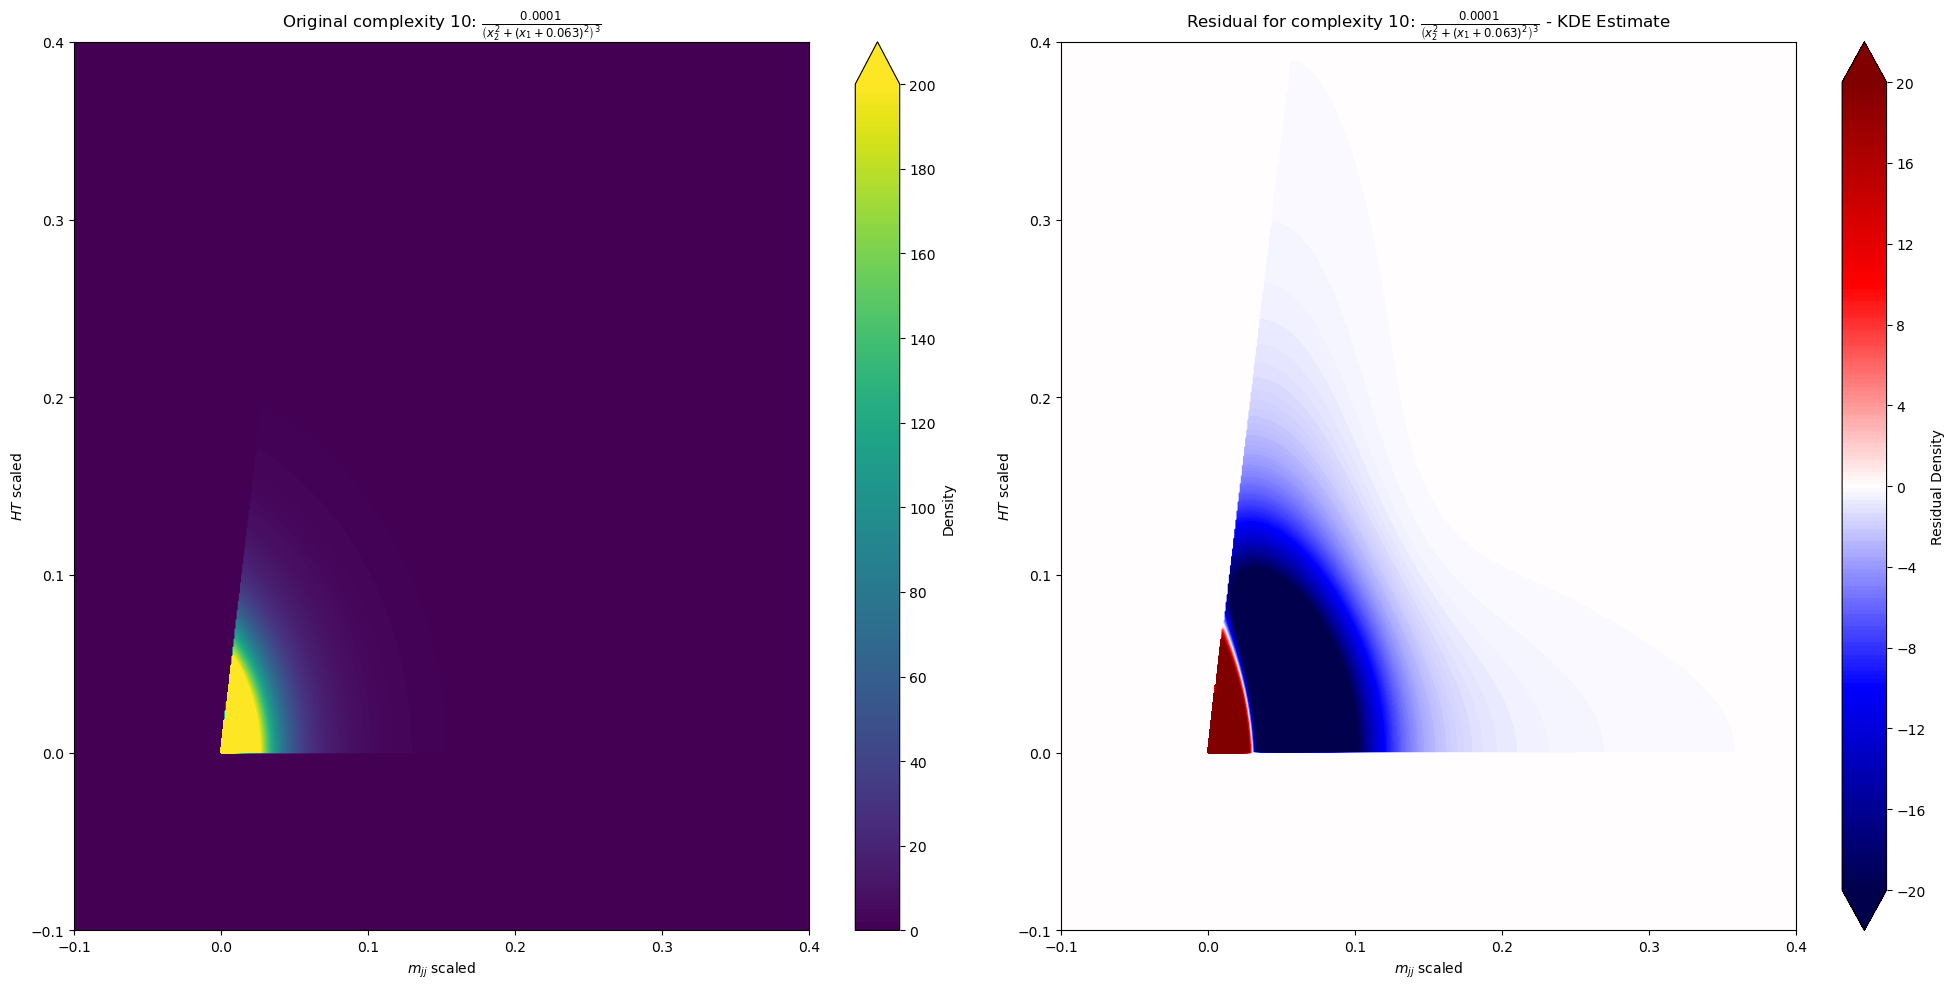

Complexity 10: Likelihood score: 54,894.27497736405
complexity 10 :: min predict: 0.00, max predict: 1585.70
complexity 10 :: min residual: -68.97, max residual: 1406.50
Complexity 10: MSE error: 3.361728e+01


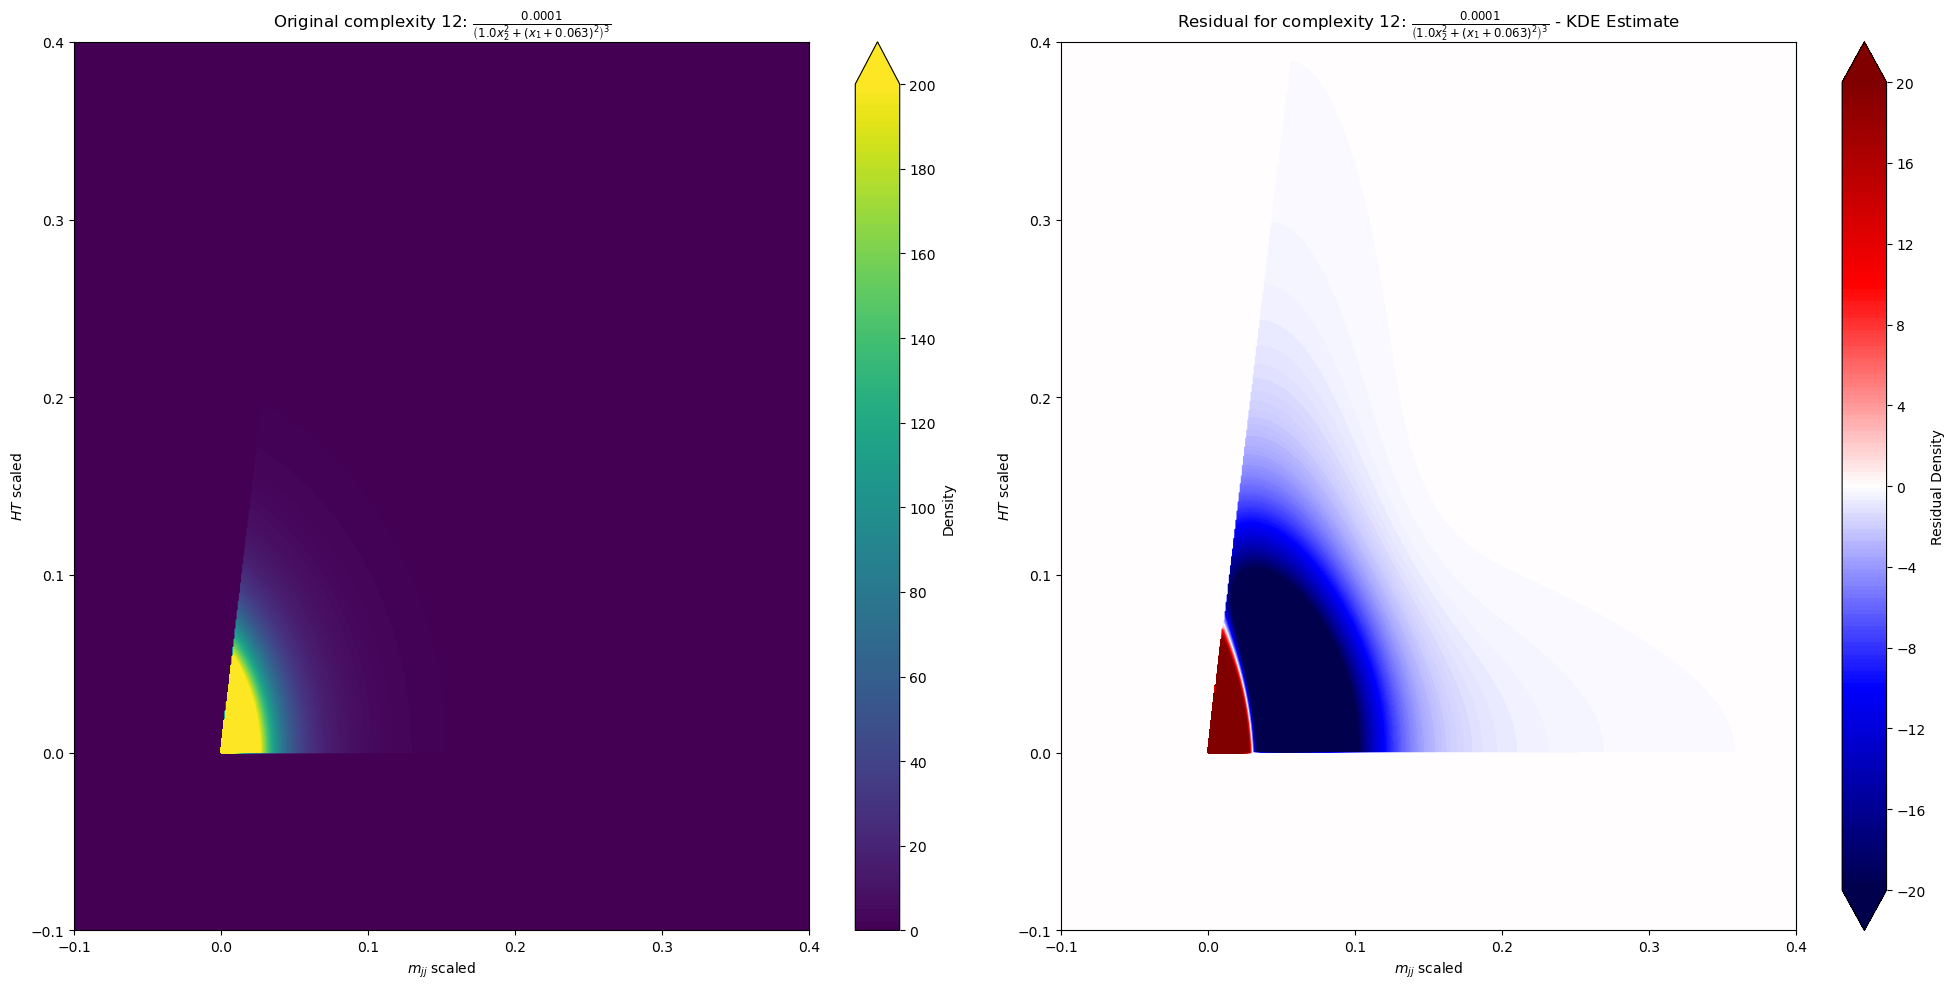

Complexity 12: Likelihood score: 54,924.51189029584
complexity 12 :: min predict: 0.00, max predict: 1585.70
complexity 12 :: min residual: -68.95, max residual: 1406.50
Complexity 12: MSE error: 3.369307e+01


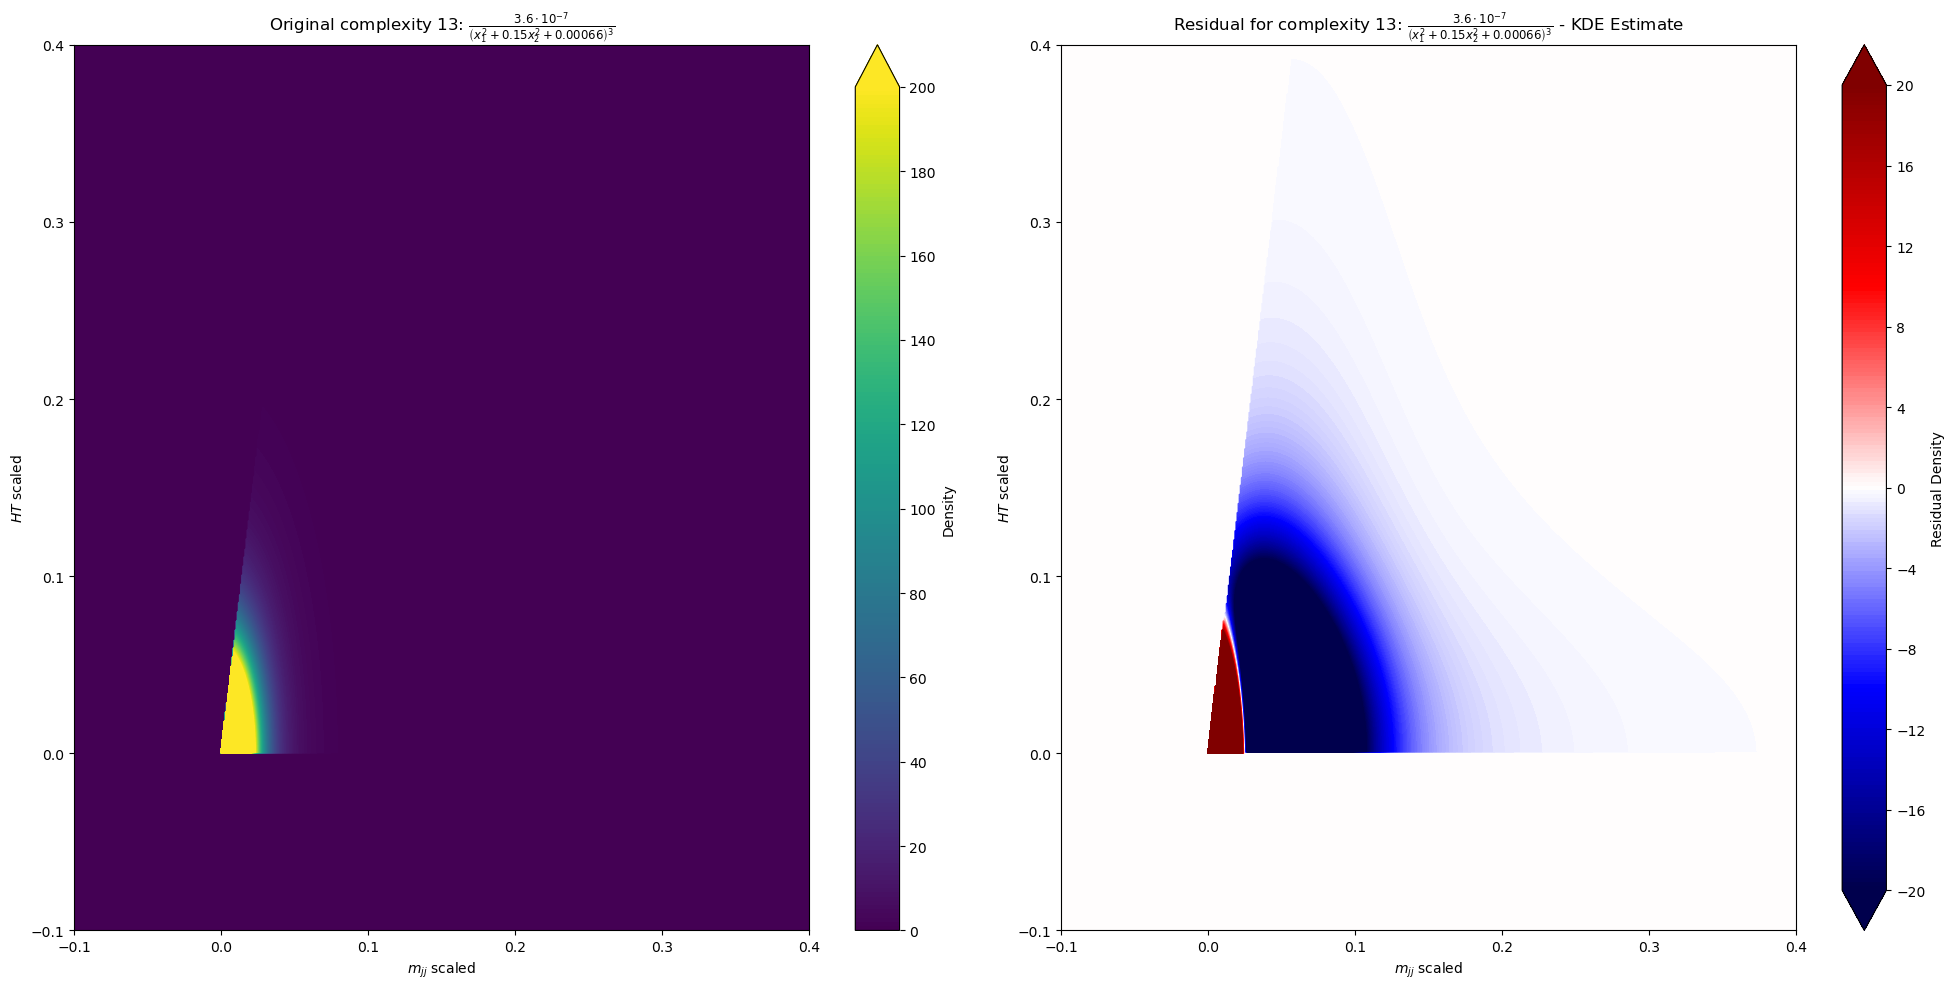

Complexity 13: Likelihood score: 51,942.328232448126
complexity 13 :: min predict: 0.00, max predict: 1210.10
complexity 13 :: min residual: -112.00, max residual: 1030.90
Complexity 13: MSE error: 3.922786e+01


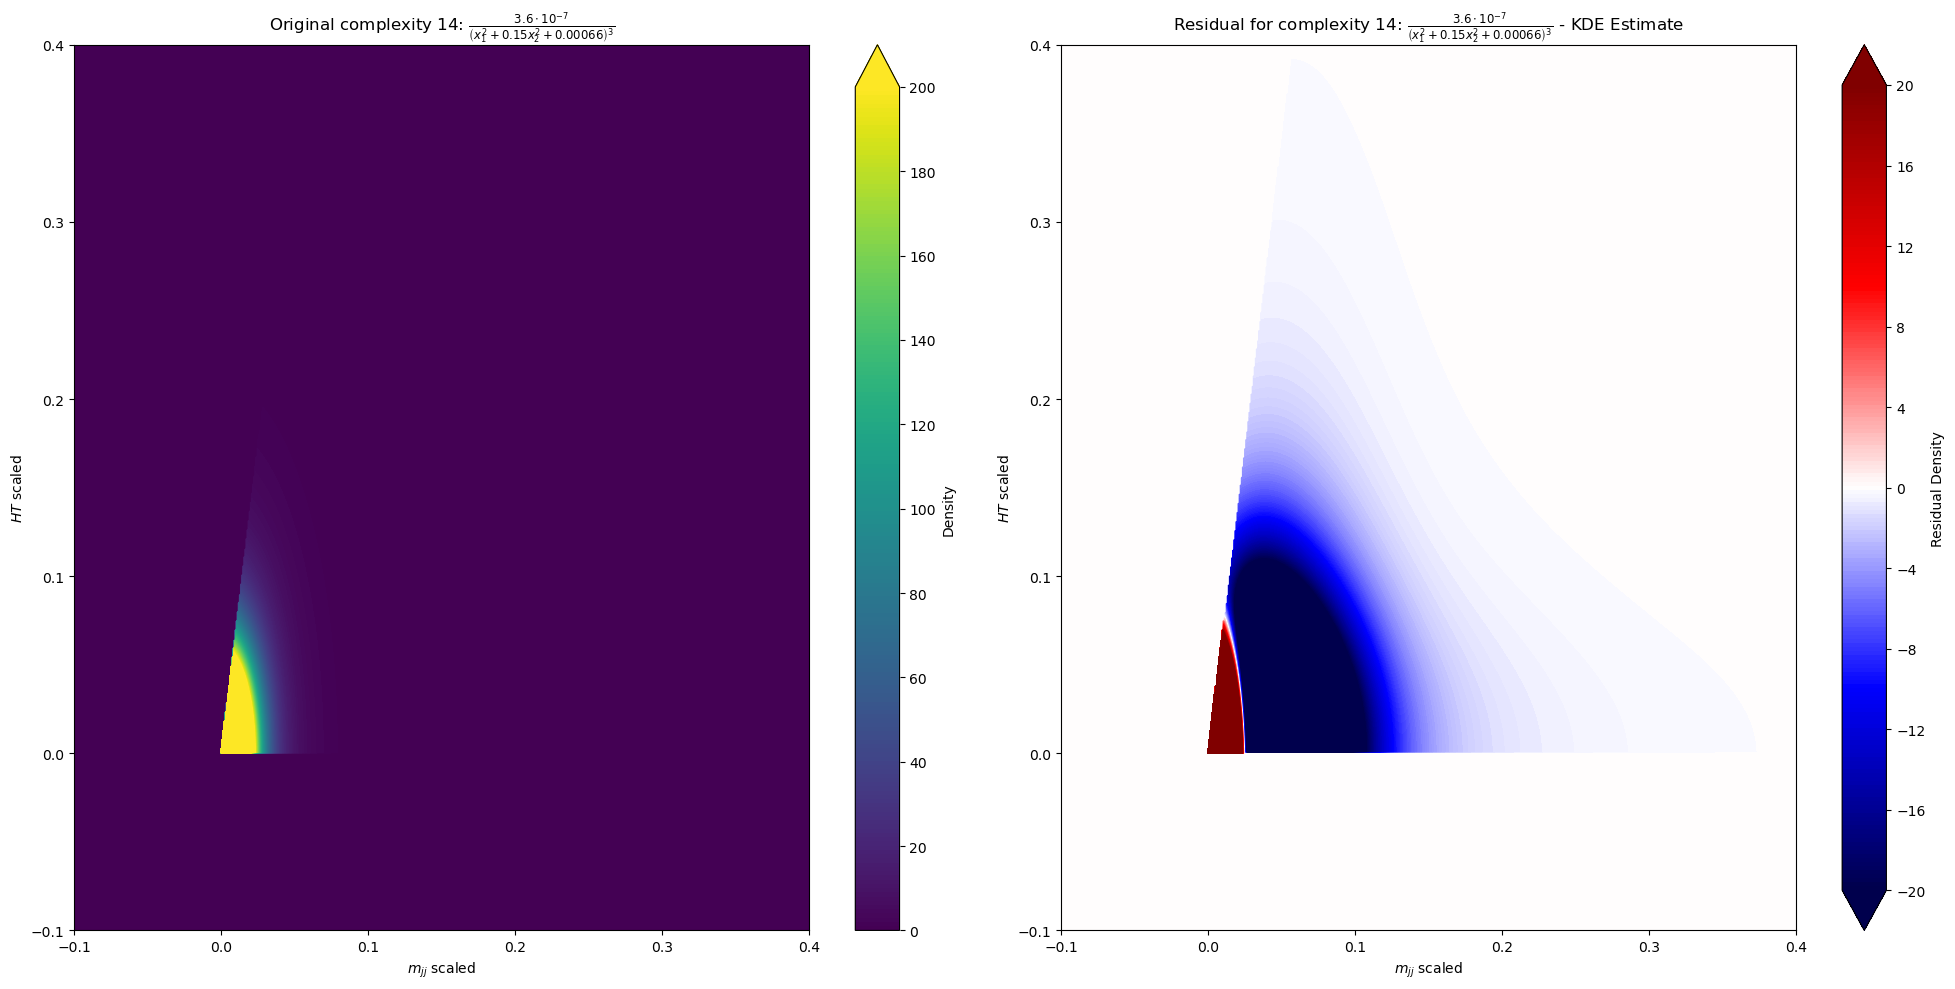

Complexity 14: Likelihood score: 51,914.925606171215
complexity 14 :: min predict: 0.00, max predict: 1204.38
complexity 14 :: min residual: -112.00, max residual: 1025.19
Complexity 14: MSE error: 3.887545e+01


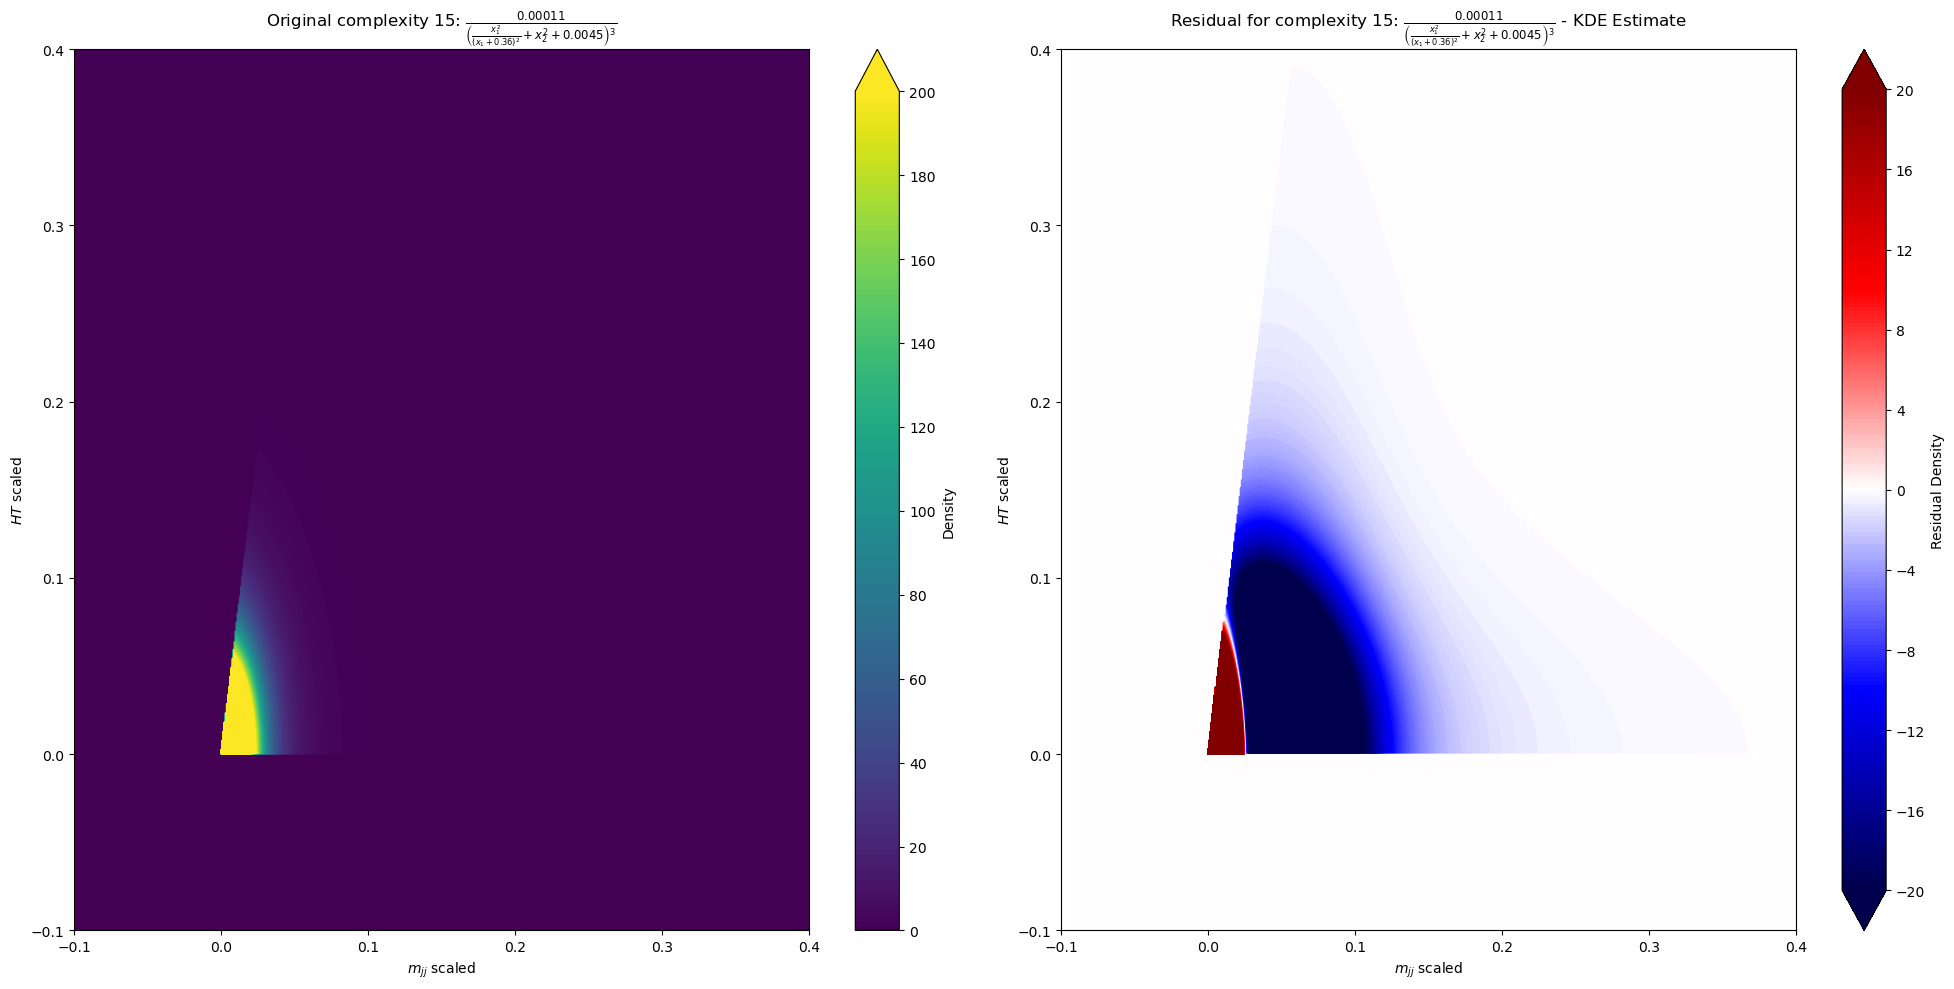

Complexity 15: Likelihood score: 53,056.365449862715
complexity 15 :: min predict: 0.00, max predict: 1210.03
complexity 15 :: min residual: -104.49, max residual: 1030.84
Complexity 15: MSE error: 3.818063e+01


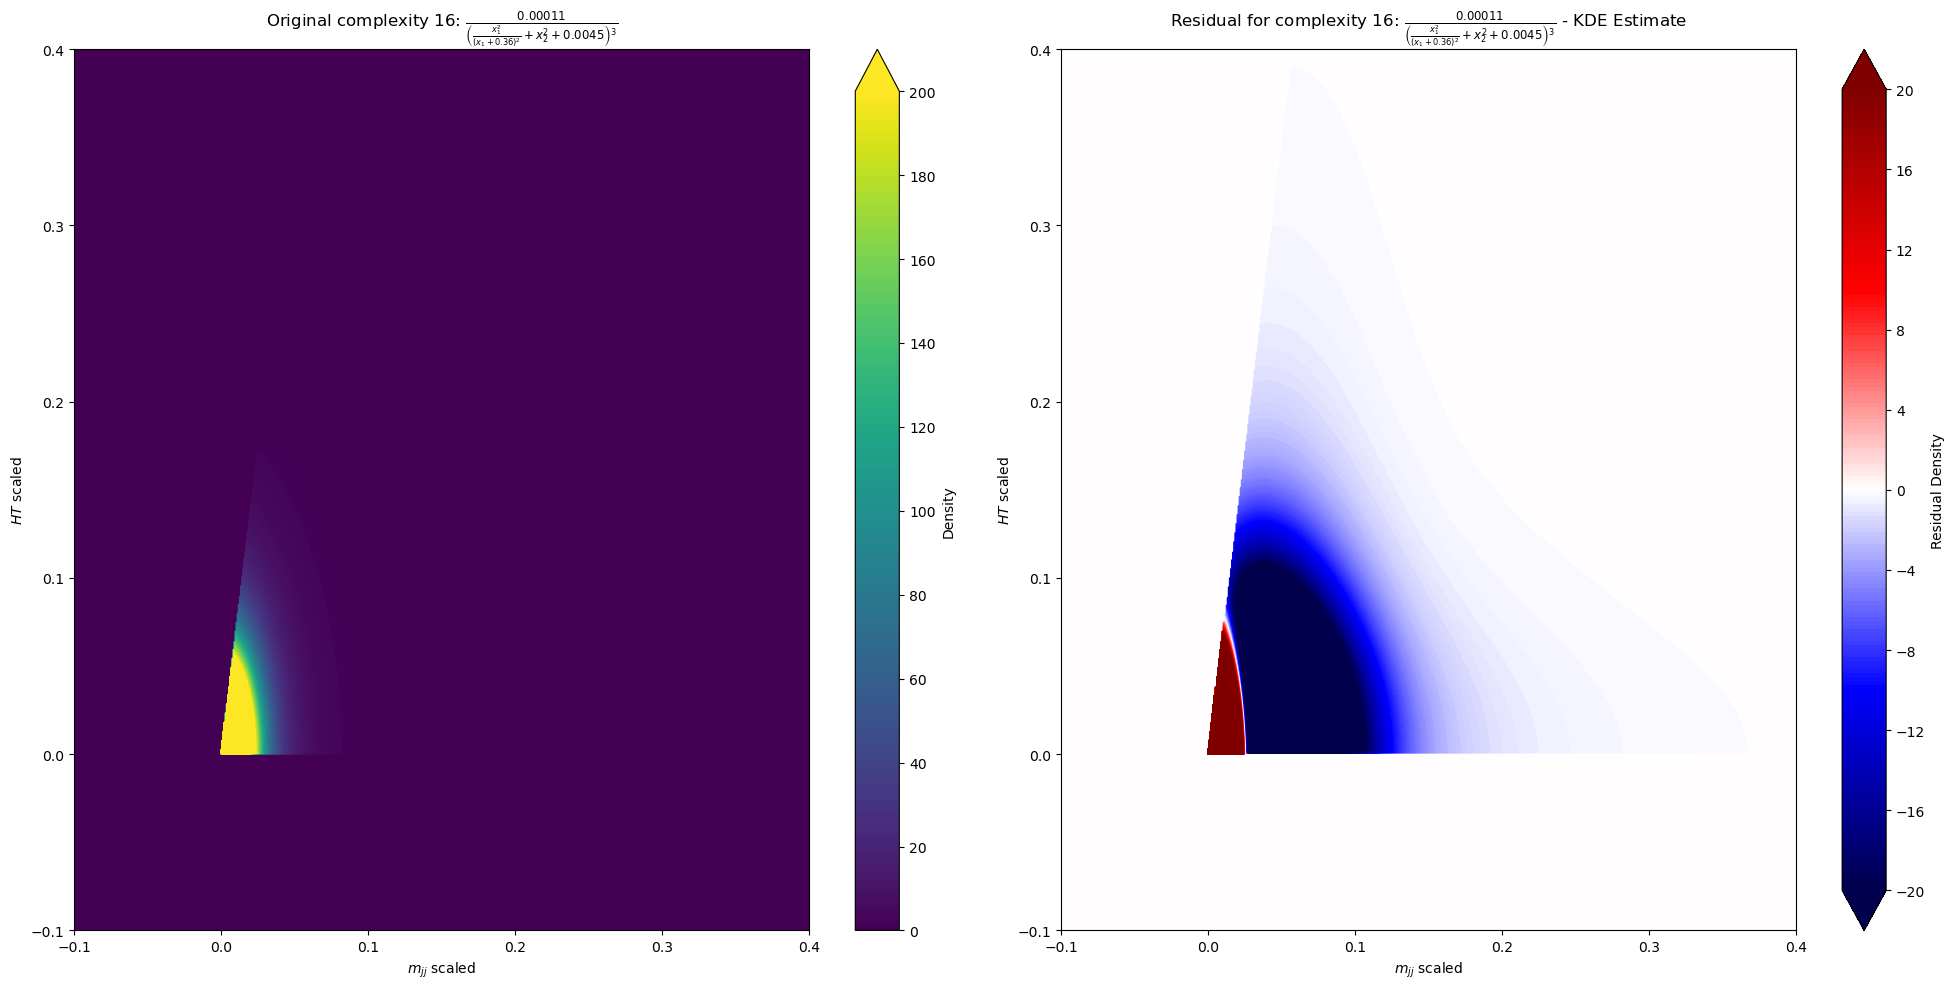

Complexity 16: Likelihood score: 53,038.52609639247
complexity 16 :: min predict: 0.00, max predict: 1210.03
complexity 16 :: min residual: -104.65, max residual: 1030.83
Complexity 16: MSE error: 3.813069e+01


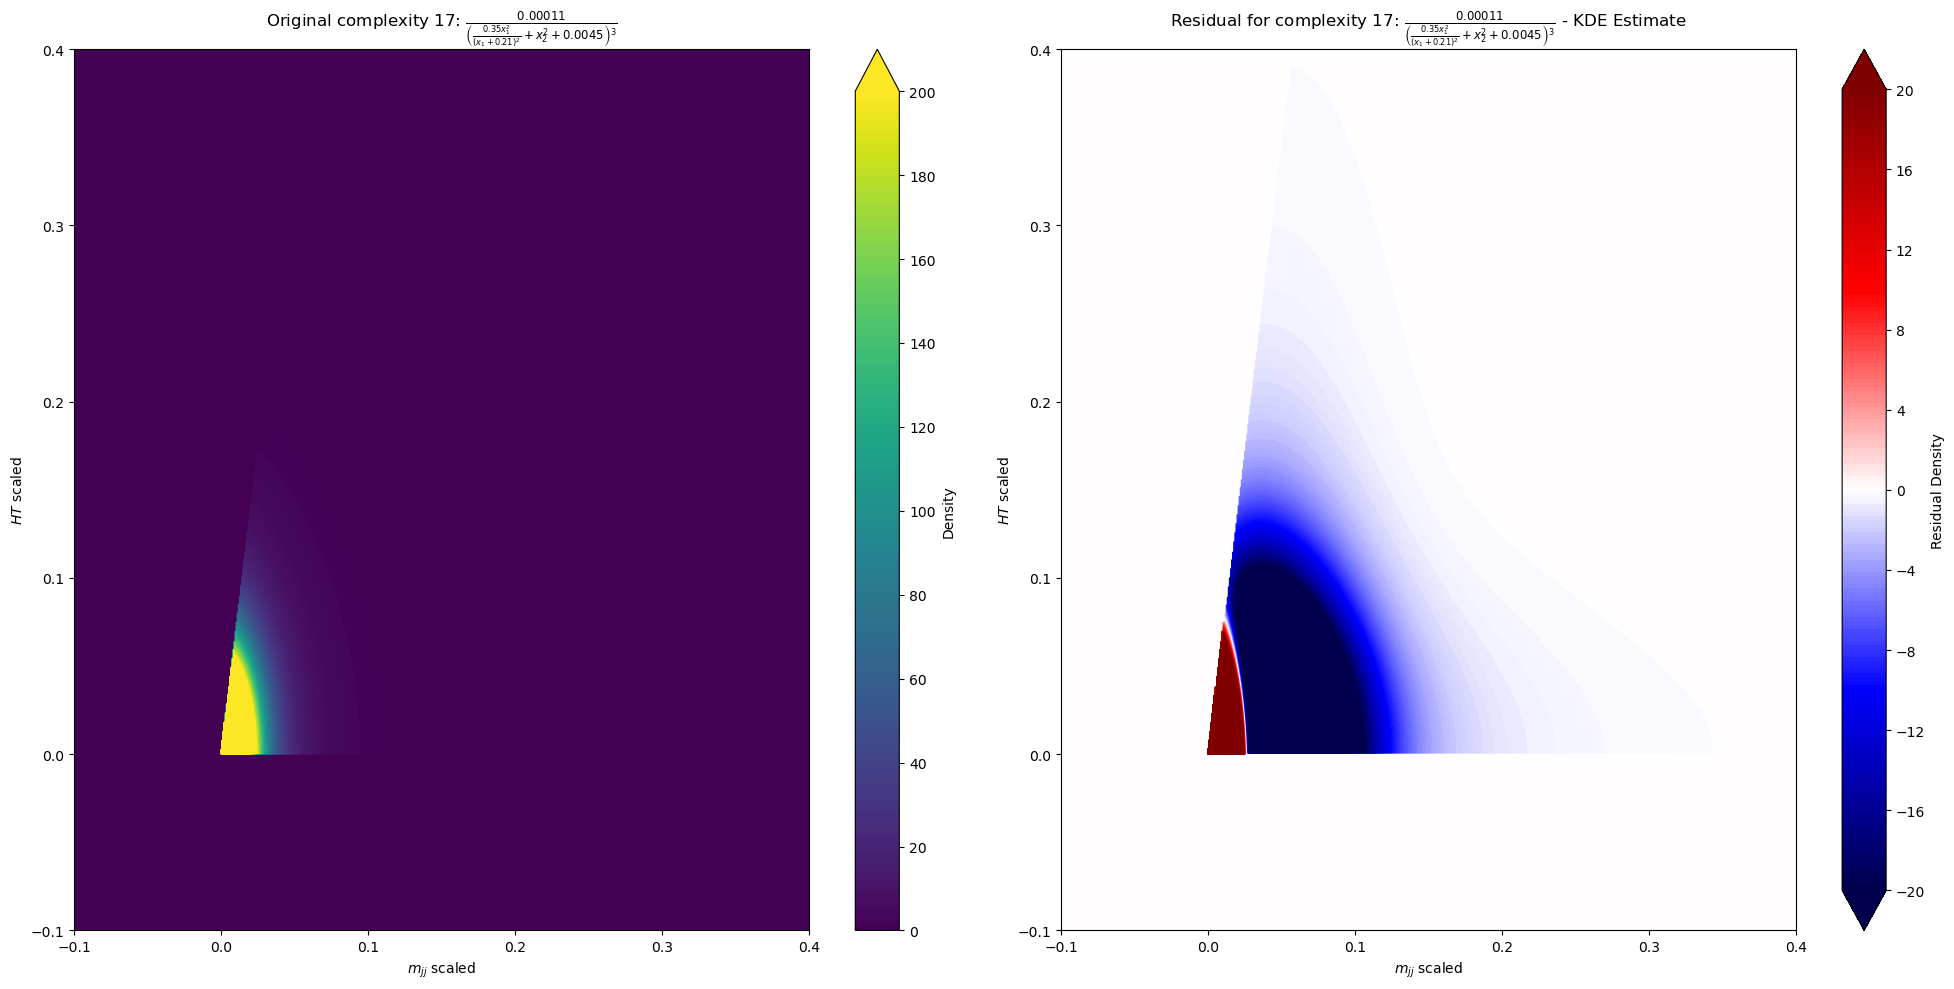

Complexity 17: Likelihood score: 53,656.17079325401
complexity 17 :: min predict: 0.00, max predict: 1209.98
complexity 17 :: min residual: -98.93, max residual: 1030.78
Complexity 17: MSE error: 3.729228e+01


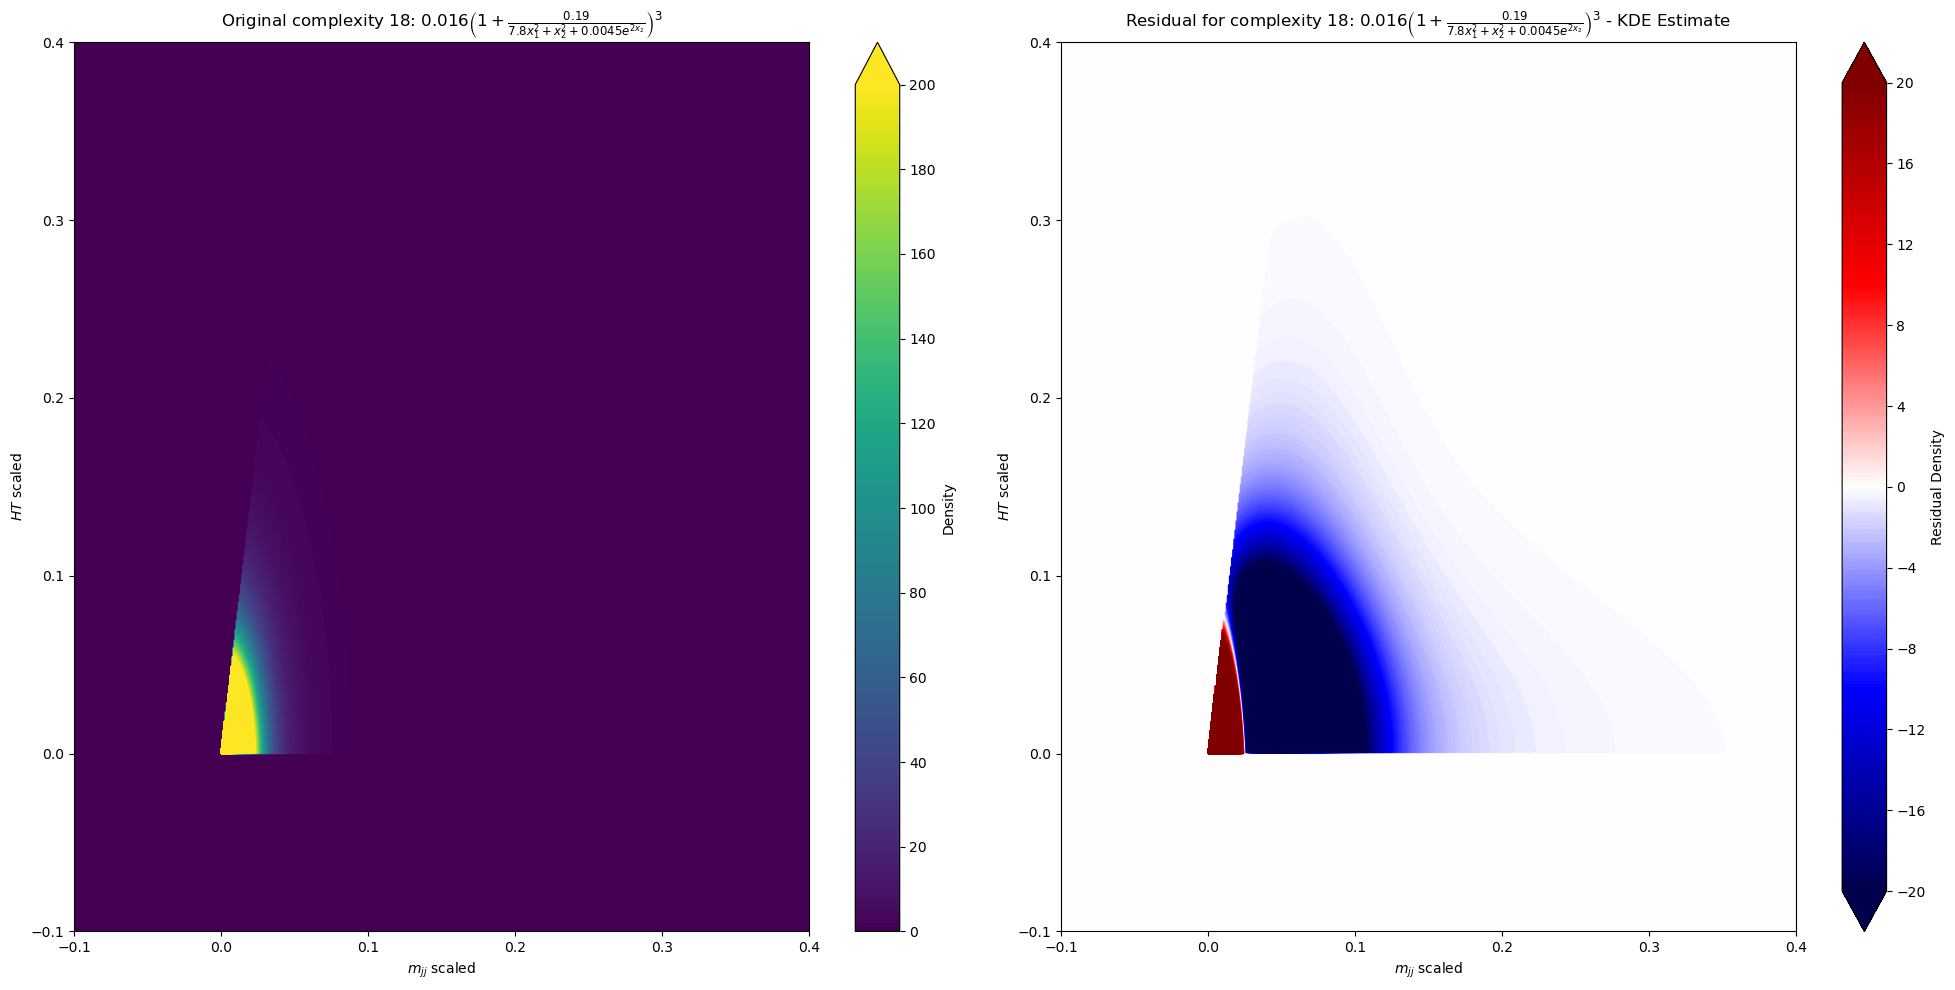

Complexity 18: Likelihood score: 52,816.32984577672
complexity 18 :: min predict: 0.00, max predict: 1294.86
complexity 18 :: min residual: -110.22, max residual: 1115.66
Complexity 18: MSE error: 3.906785e+01


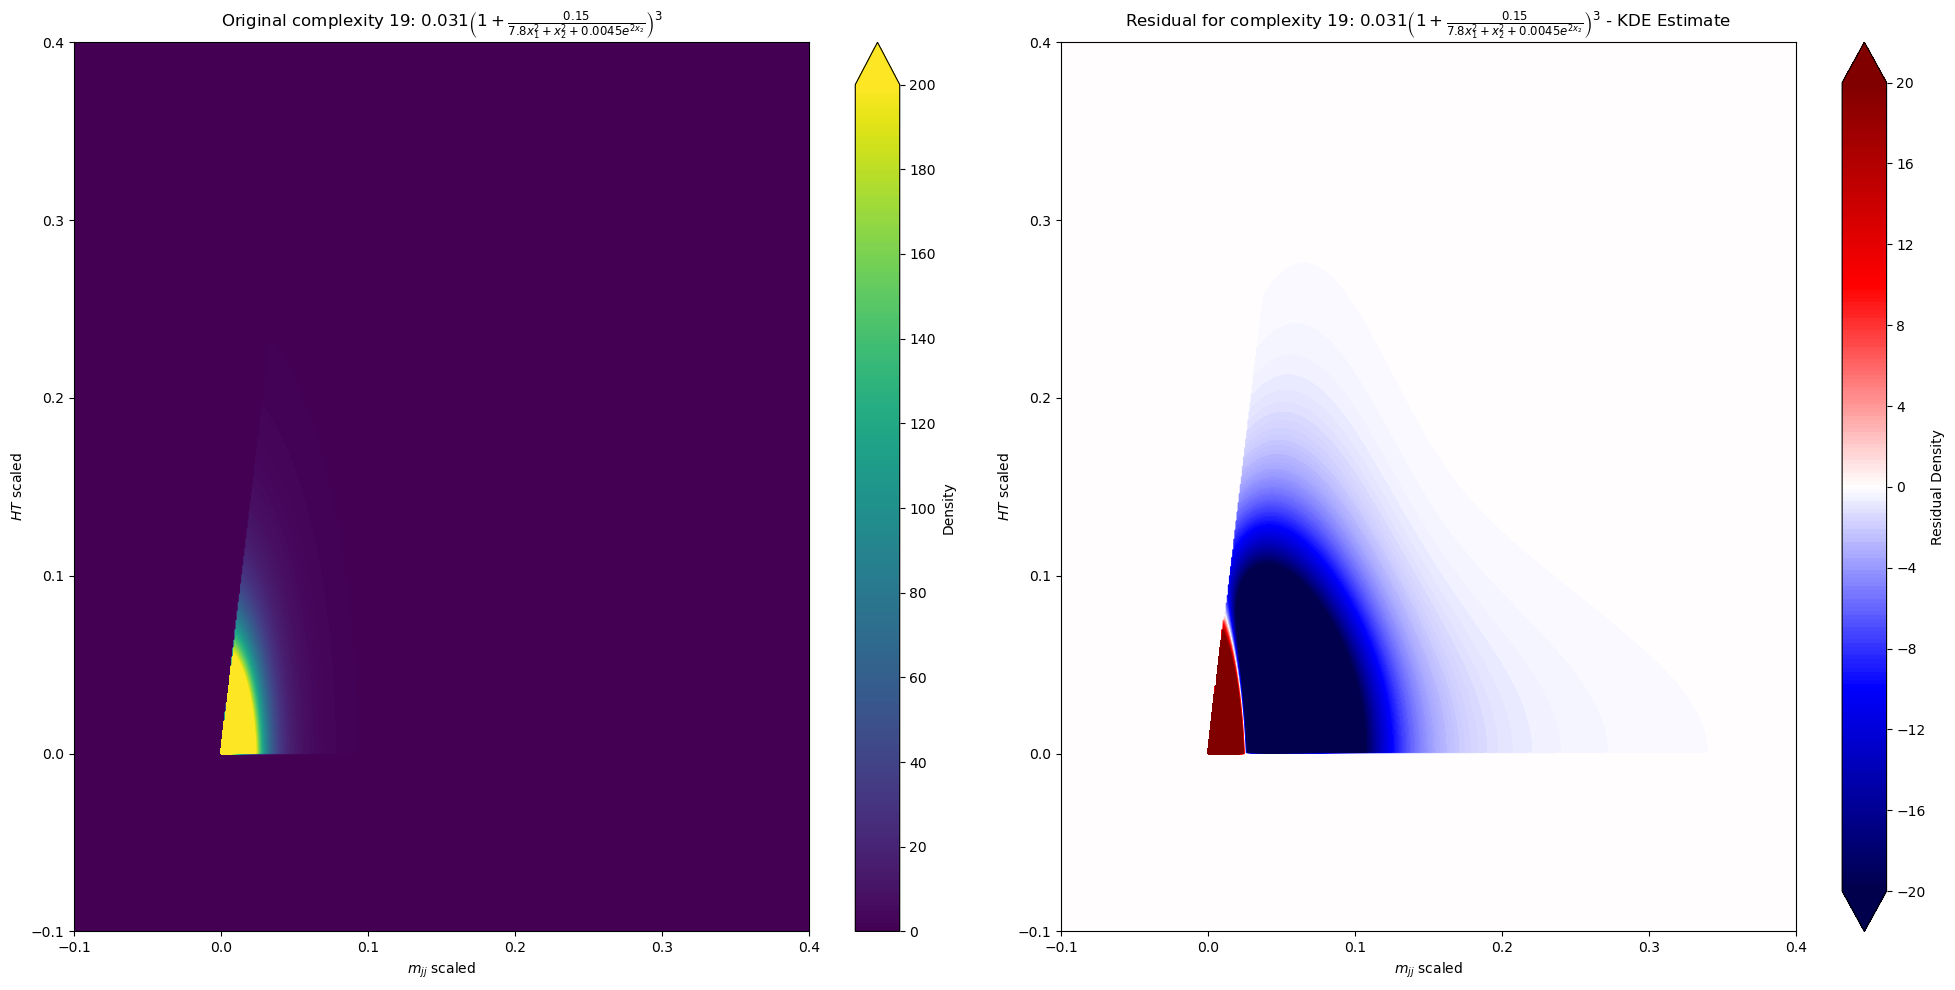

Complexity 19: Likelihood score: 53,242.60412693773
complexity 19 :: min predict: 0.00, max predict: 1315.36
complexity 19 :: min residual: -108.81, max residual: 1136.16
Complexity 19: MSE error: 4.058440e+01


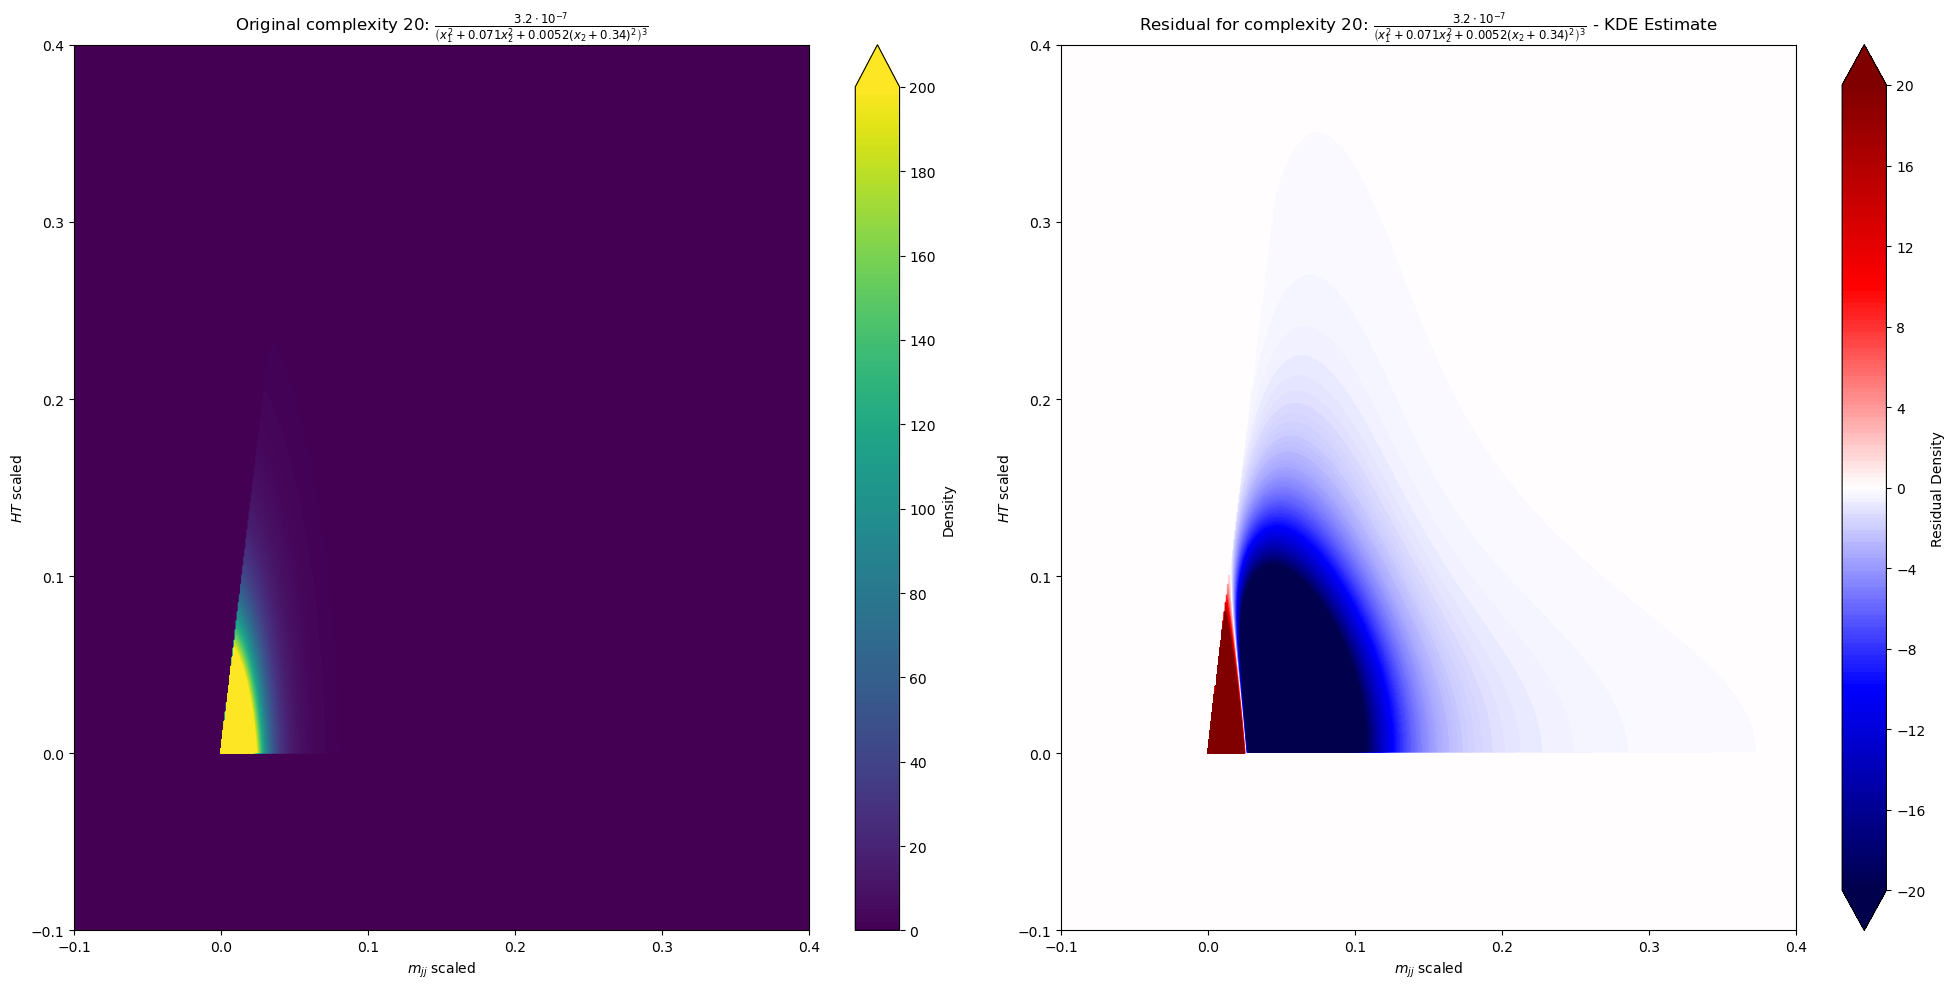

Complexity 20: Likelihood score: 52,376.78738110554
complexity 20 :: min predict: 0.00, max predict: 1348.75
complexity 20 :: min residual: -110.68, max residual: 1169.55
Complexity 20: MSE error: 3.842294e+01


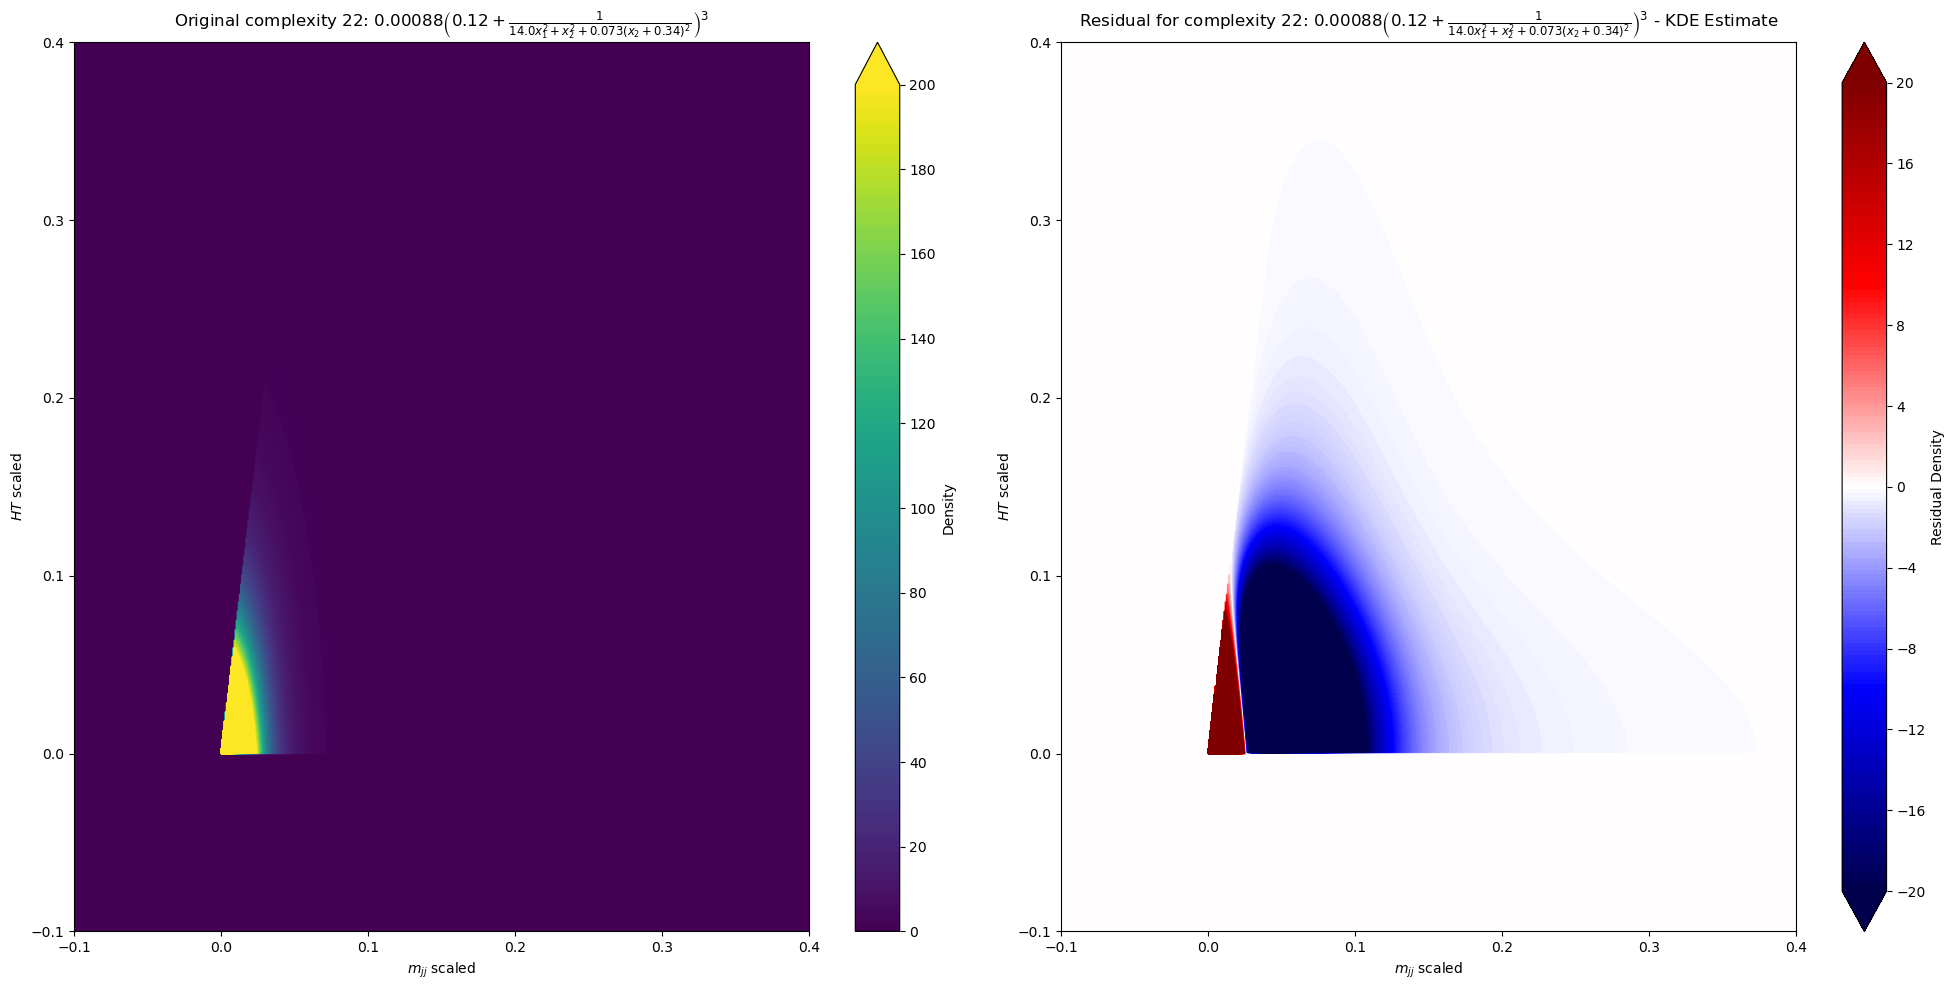

Complexity 22: Likelihood score: 52,495.97504115772
complexity 22 :: min predict: 0.00, max predict: 1353.18
complexity 22 :: min residual: -110.39, max residual: 1173.98
Complexity 22: MSE error: 3.873892e+01


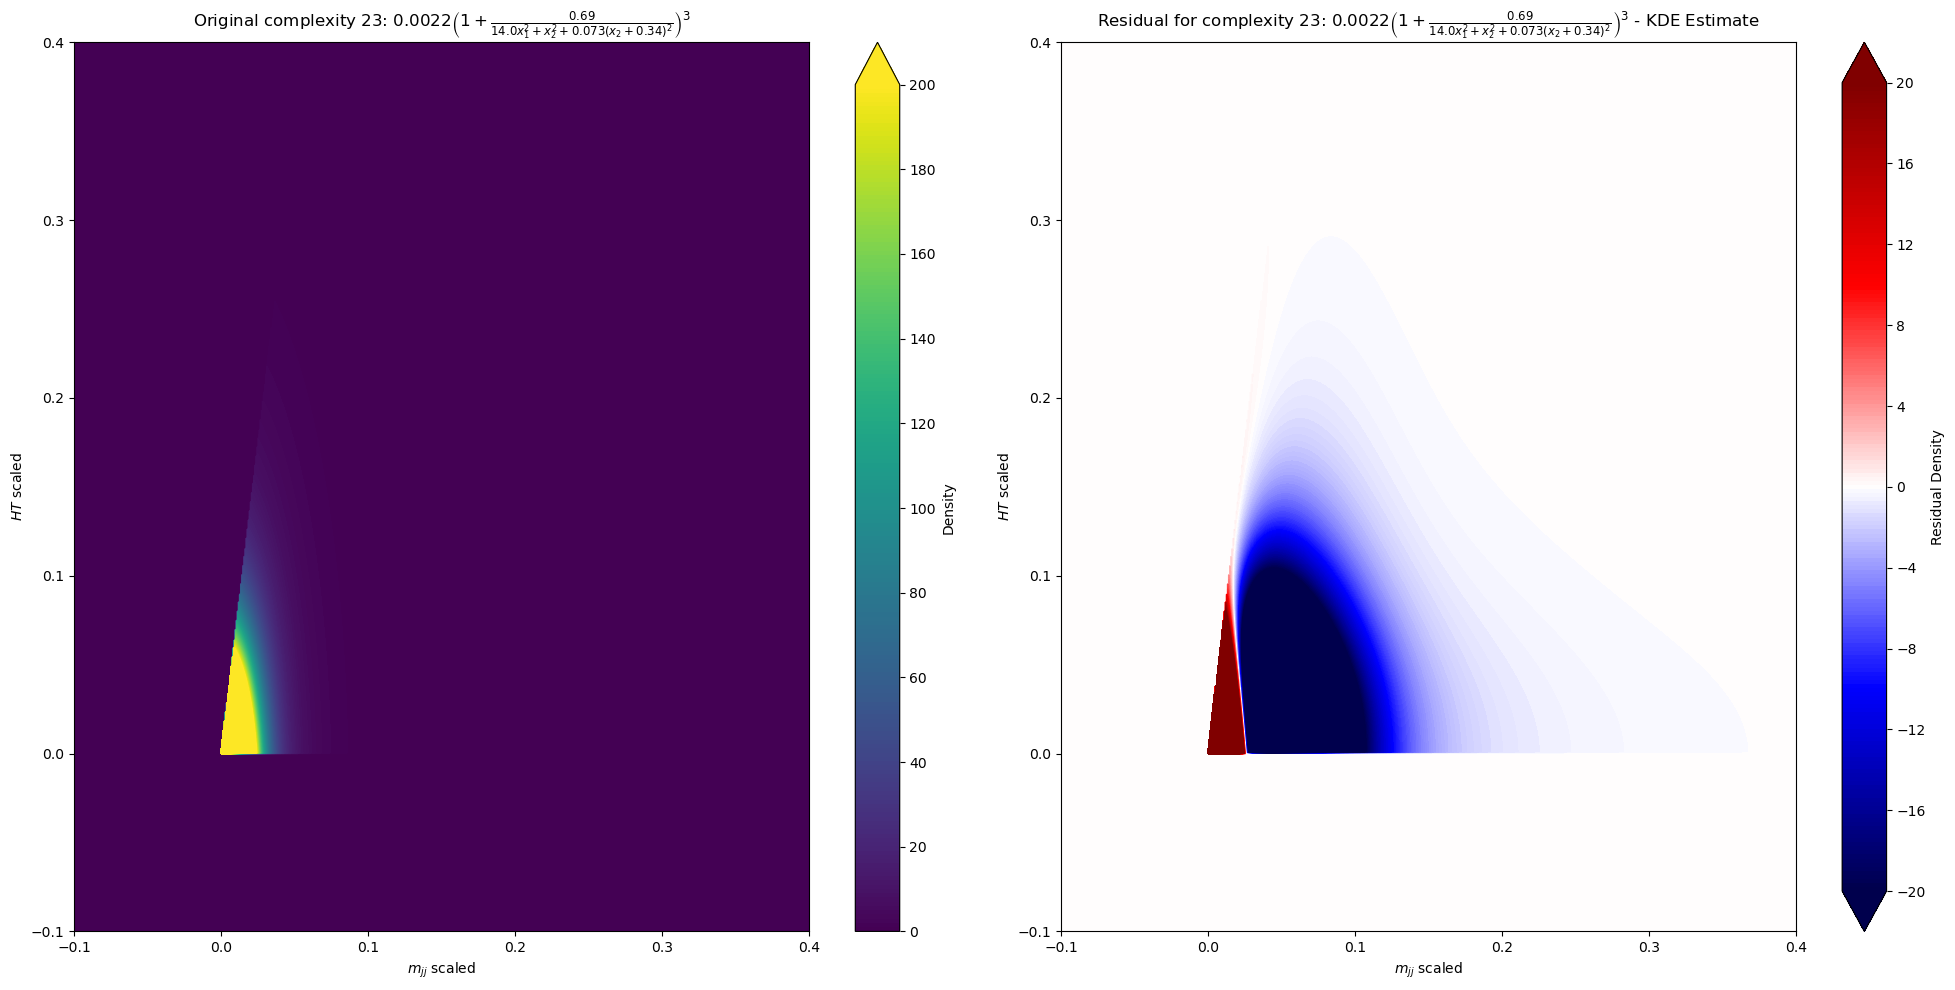

Complexity 23: Likelihood score: 53,080.832419565595
complexity 23 :: min predict: 0.00, max predict: 1334.81
complexity 23 :: min residual: -108.48, max residual: 1155.61
Complexity 23: MSE error: 3.794772e+01


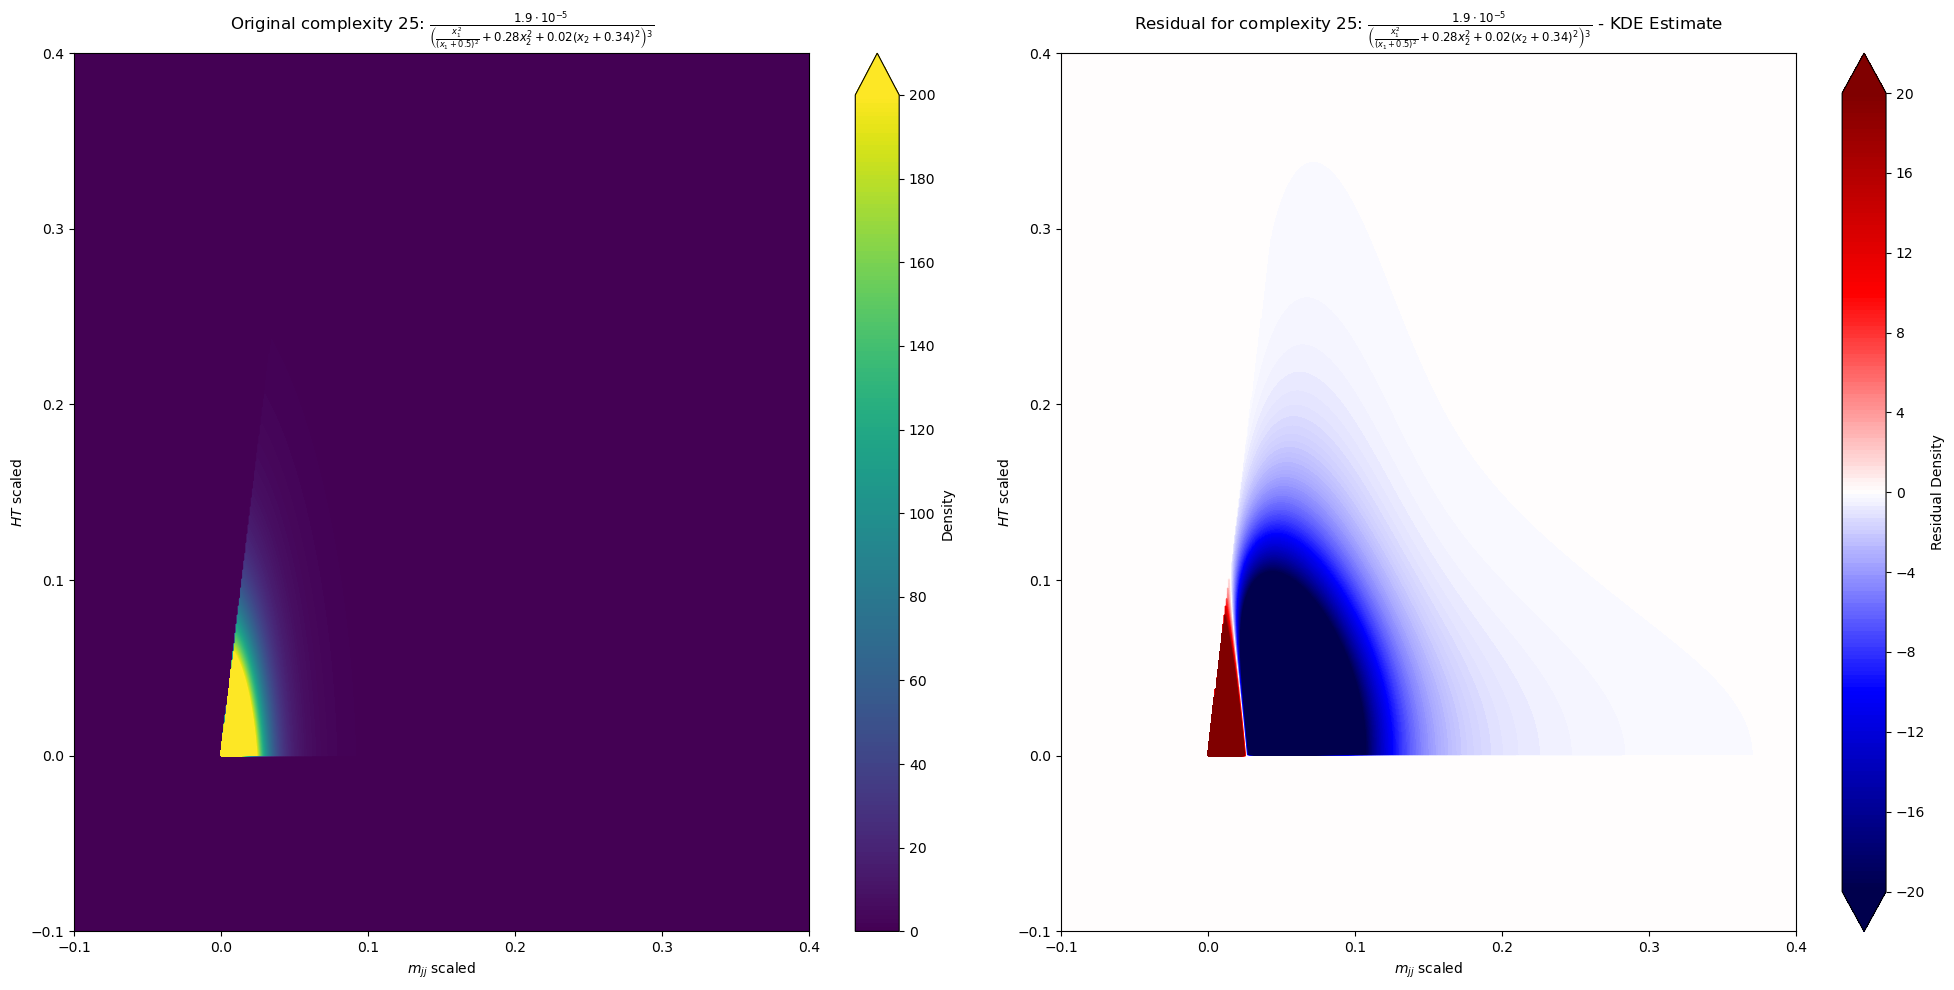

Complexity 25: Likelihood score: 53,107.26249880696
complexity 25 :: min predict: 0.00, max predict: 1348.68
complexity 25 :: min residual: -106.11, max residual: 1169.48
Complexity 25: MSE error: 3.737957e+01


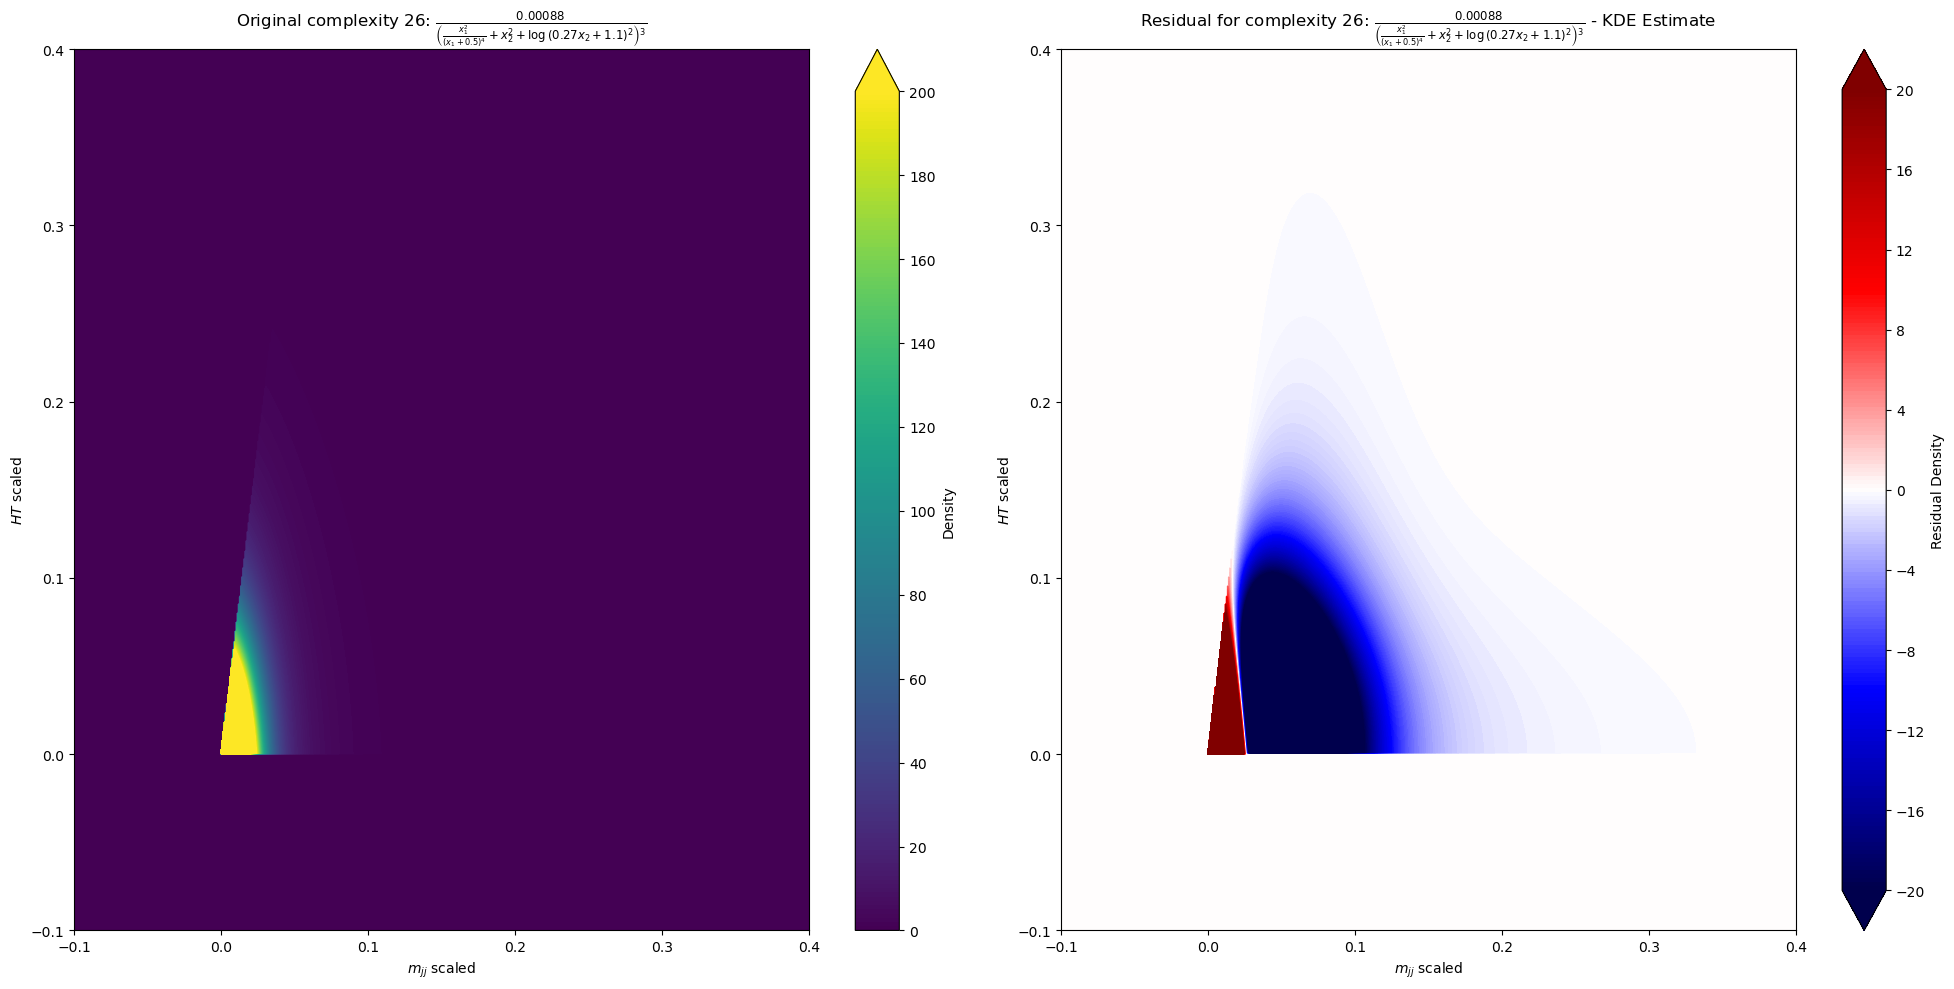

Complexity 26: Likelihood score: 53,837.68310193217
complexity 26 :: min predict: 0.00, max predict: 1349.36
complexity 26 :: min residual: -102.52, max residual: 1170.16
Complexity 26: MSE error: 3.711389e+01


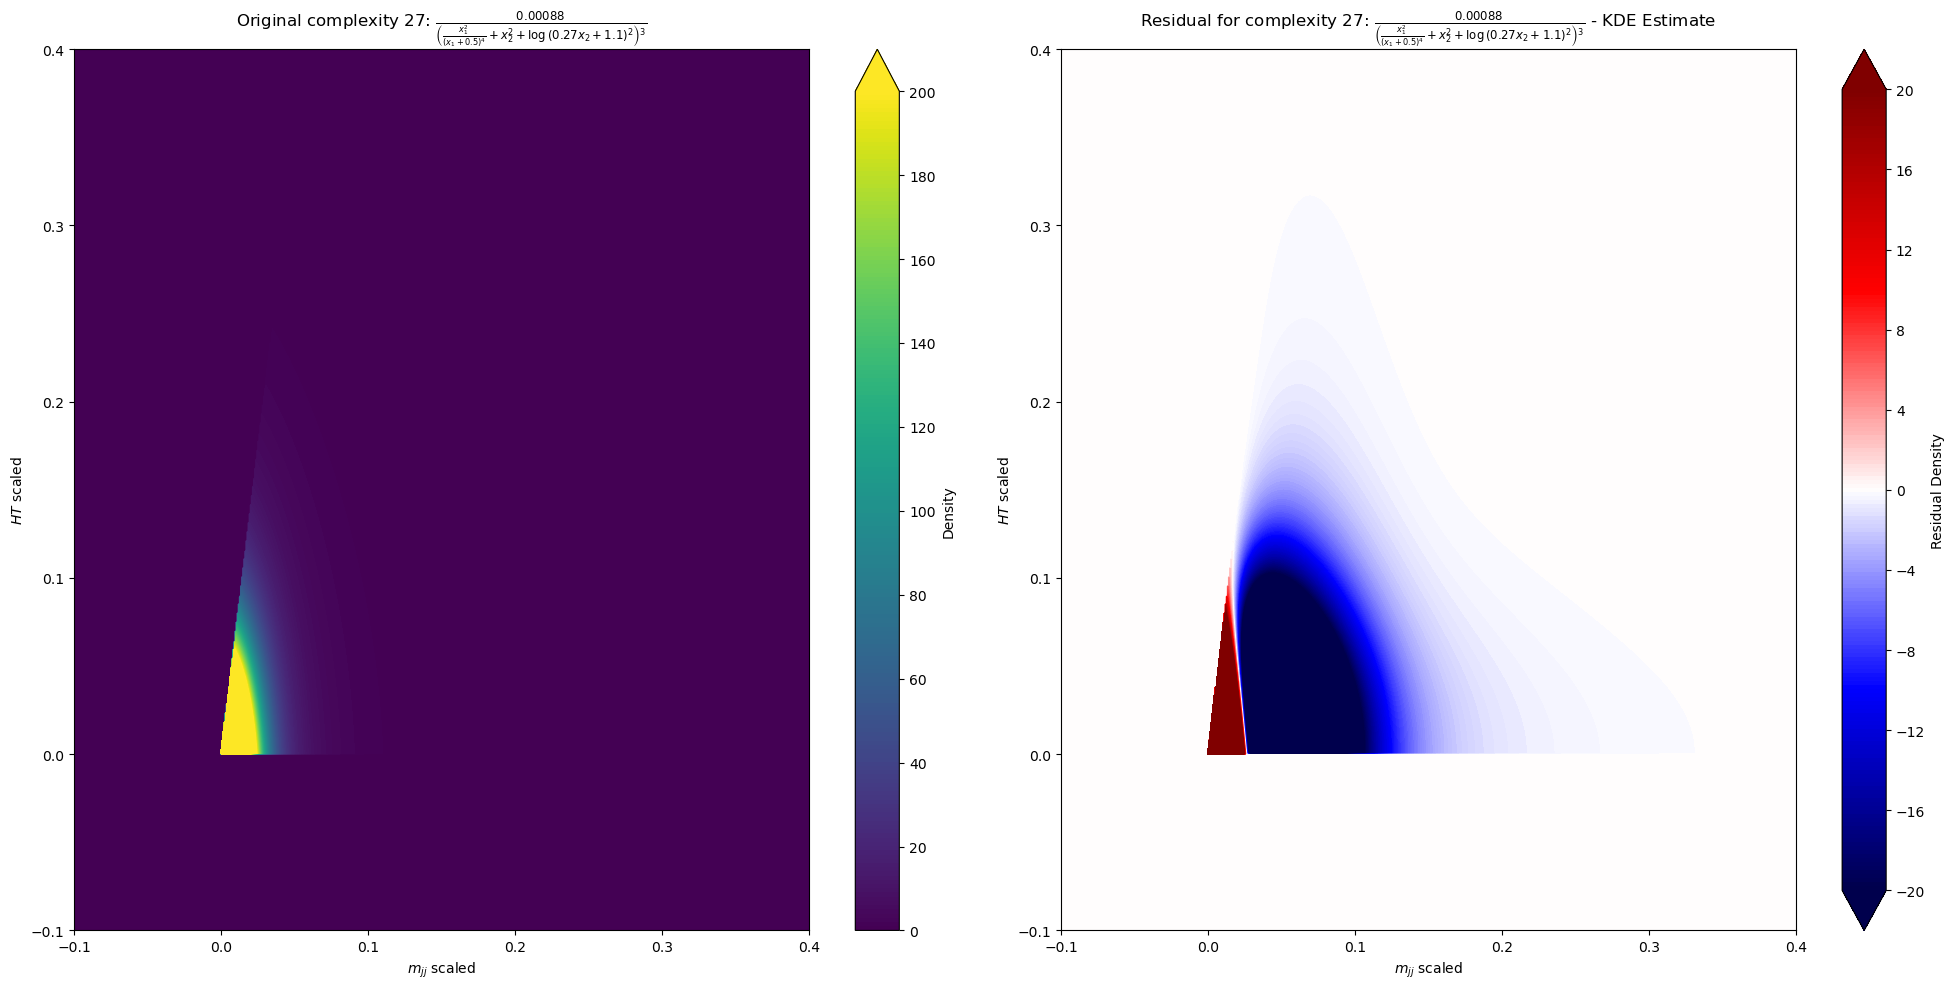

Complexity 27: Likelihood score: 53,946.08670307431
complexity 27 :: min predict: 0.00, max predict: 1349.38
complexity 27 :: min residual: -101.57, max residual: 1170.18
Complexity 27: MSE error: 3.739509e+01


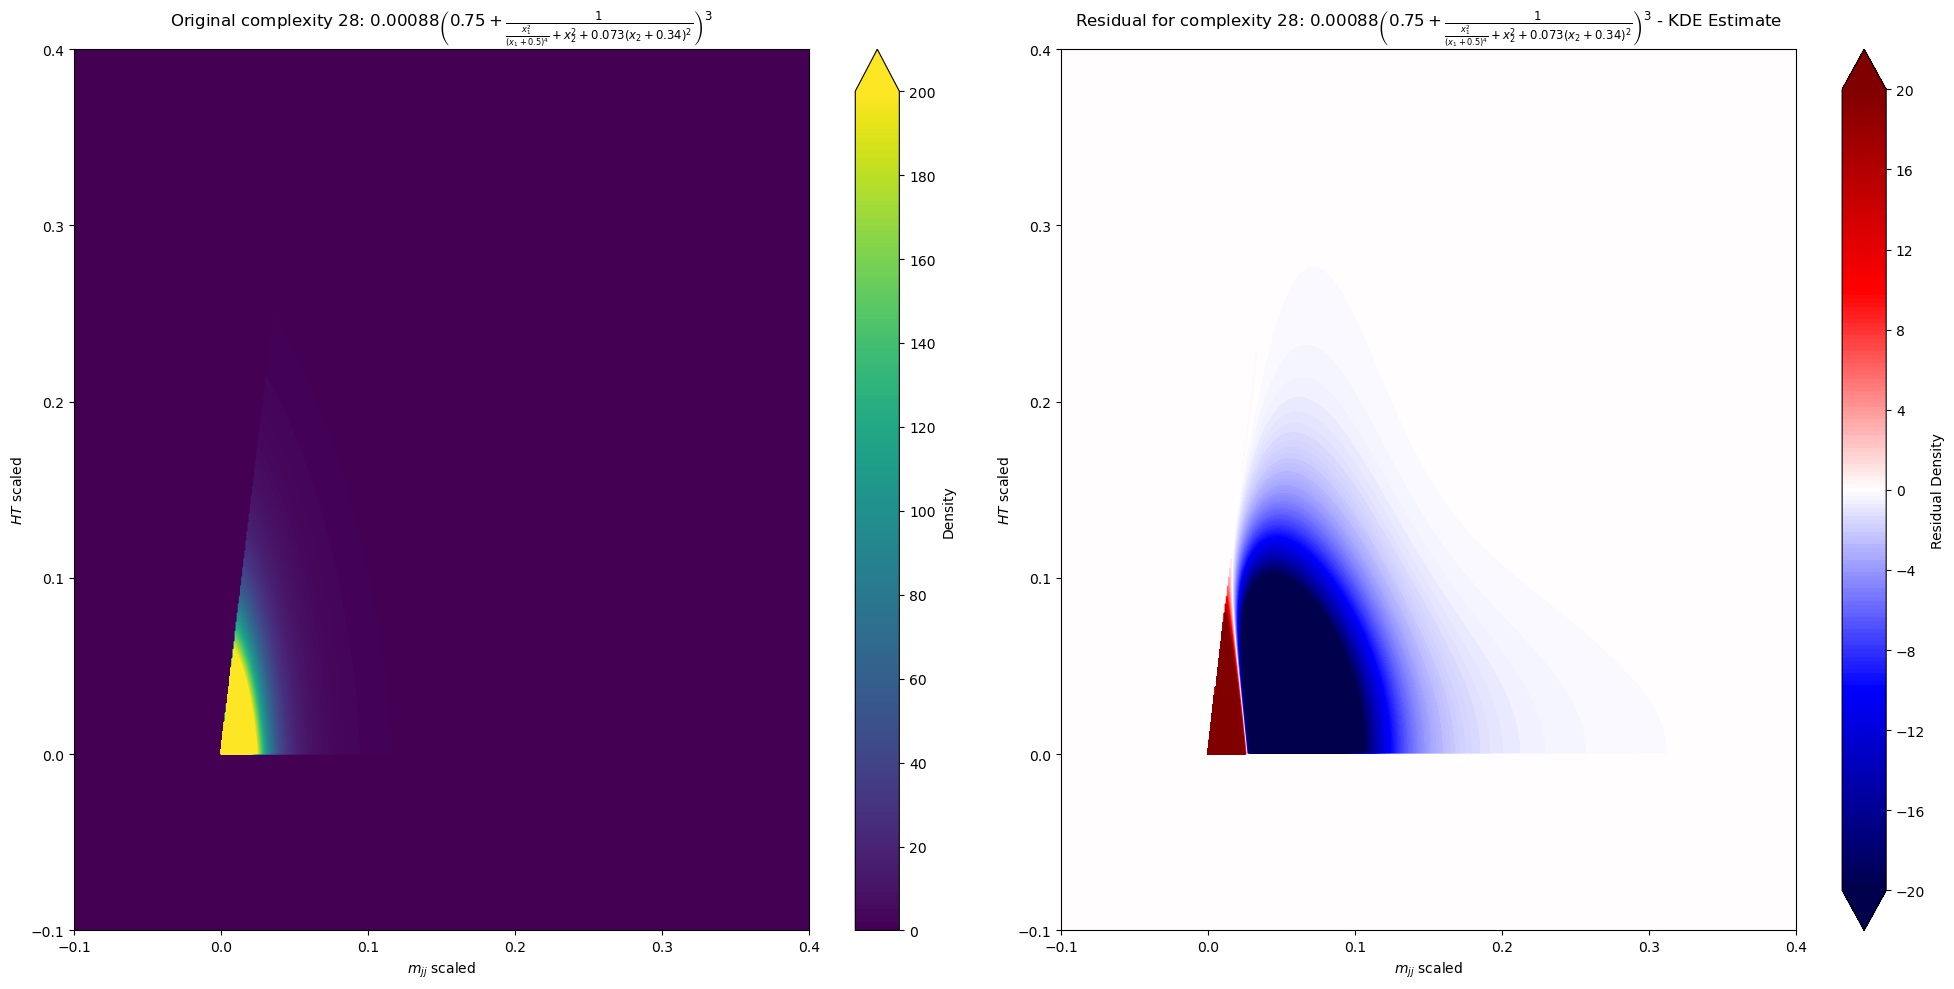

Complexity 28: Likelihood score: 54,098.06510885015
complexity 28 :: min predict: 0.00, max predict: 1375.14
complexity 28 :: min residual: -100.64, max residual: 1195.94
Complexity 28: MSE error: 3.759879e+01


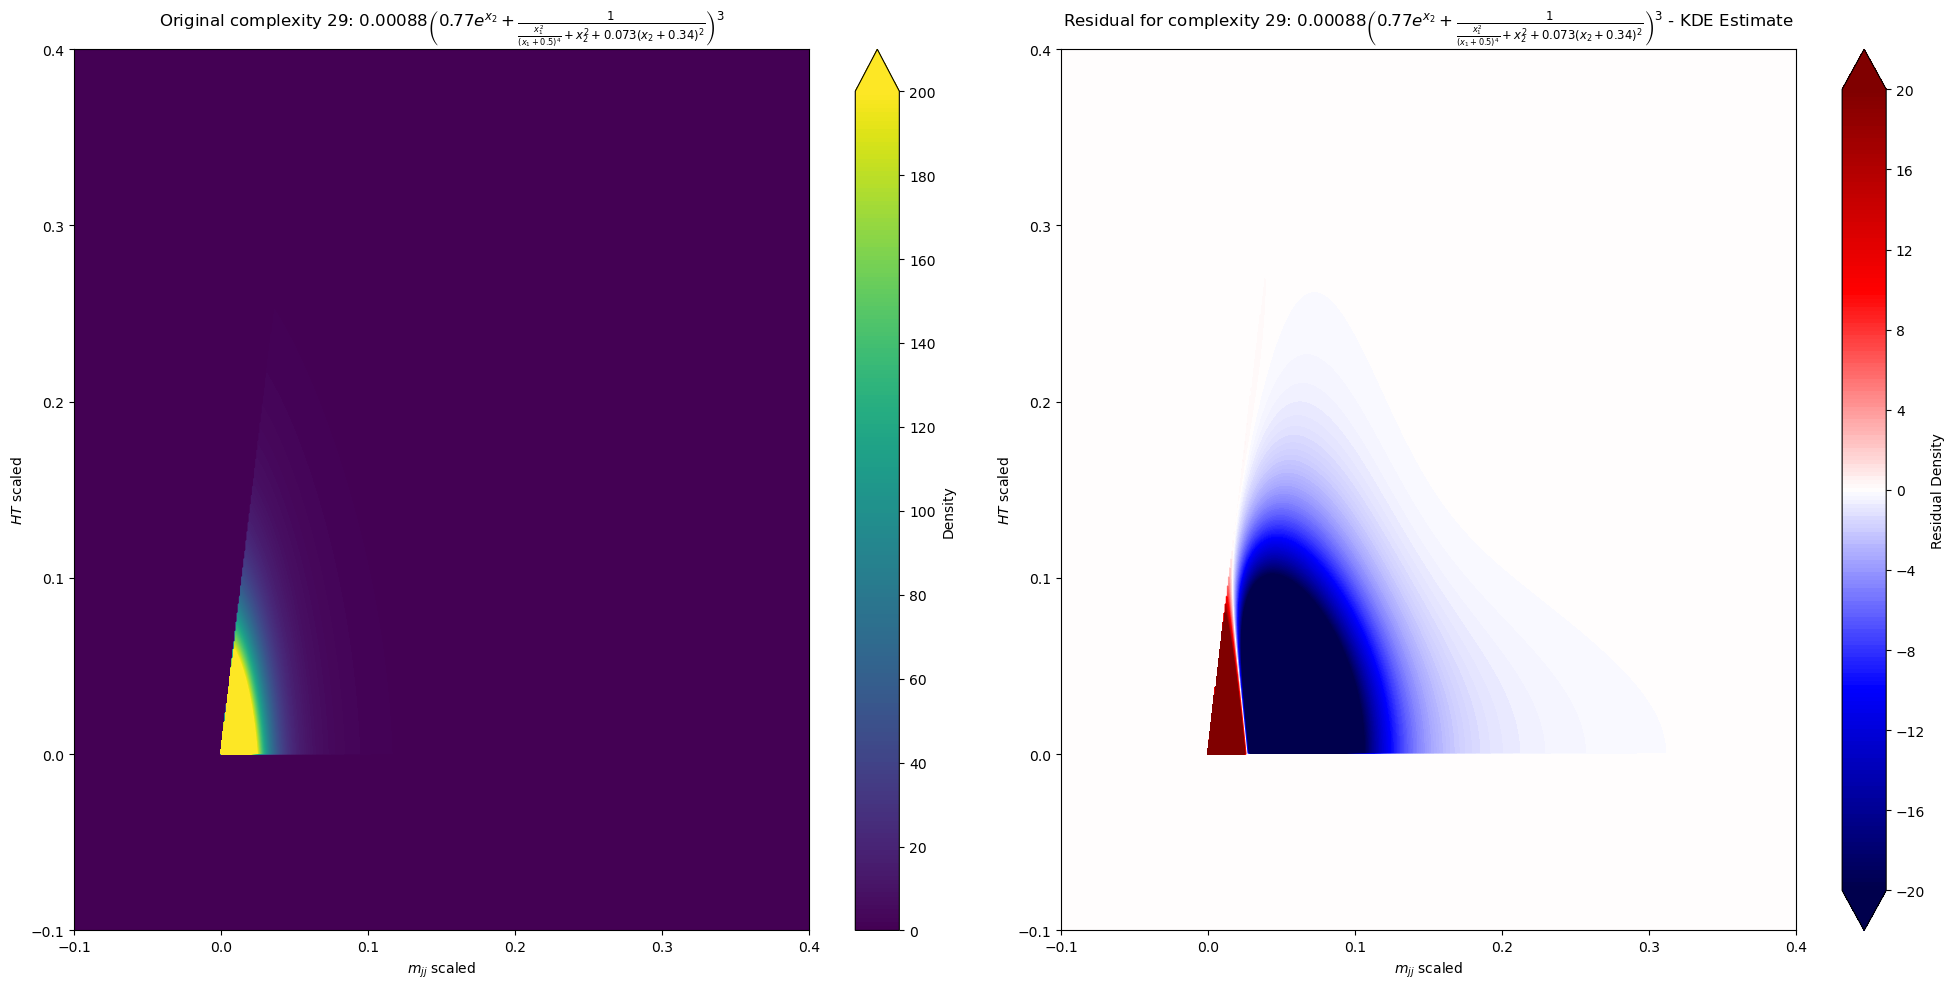

Complexity 29: Likelihood score: 54,136.67457061136
complexity 29 :: min predict: 0.00, max predict: 1375.81
complexity 29 :: min residual: -100.56, max residual: 1196.61
Complexity 29: MSE error: 3.766447e+01
Finished generating and saving plots for 25 functions.


In [21]:
# Iterate over the masked_functions list
for i, current_function in enumerate(masked_functions):
    # Skip if the function is not defined or you only want to plot specific ones
    # if i not in [2, 5]:  # Example: plot only indices 2 and 5
    #     continue

    # Get the title for the current function
    title = latex_labels[i]

    # Create a new figure for each iteration
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # --- Plot 1: Original Function Plot (current_function) ---
    ax1 = axes[0]
    
    # Calculate the function output
    function_output = current_function(grids[0], grids[1], mask)
    if np.shape(function_output) == (1,1):
        function_output = function_output*np.ones(grids[0].shape)

    # Set levels based on your required range
    levels_original = np.linspace(level_min, level_max, 200)
    
    contour1 = ax1.contourf(
        grids[0], grids[1],
        function_output/density_scale_factor,
        levels=levels_original,
        cmap='viridis',
        extend='max'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour1, ax=ax1, label="Density", ticks=np.linspace(level_min, level_max, 11))
    
    ax1.set_xlabel(r"$m_{jj}$ scaled")
    ax1.set_ylabel(r"$HT$ scaled")
    ax1.set_title(f"Original complexity {complexity[i]}: {title}")
    ax1.set_xlim(-0.1, 0.4)
    ax1.set_ylim(-0.1, 0.4)

    # --- Plot 2: Residual Plot (current_function - sum_grid) ---
    ax2 = axes[1]
    
    # Calculate the residual
    residual_output = function_output/density_scale_factor - kde_predicted_density
    
    # Set levels for the residual plot (should be symmetric around zero)
    levels_residual = np.linspace(level_min_delta, level_max_delta, 200)
    
    contour2 = ax2.contourf(
        grids[0], grids[1],
        residual_output,
        levels=levels_residual,
        cmap='seismic', # 'seismic' is good for residuals (zero in the middle)
        extend='both'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour2, ax=ax2, label="Residual Density", ticks=np.linspace(level_min_delta, level_max_delta, 11))
    
    ax2.set_xlabel(r"$m_{jj}$ scaled")
    ax2.set_ylabel(r"$HT$ scaled")
    ax2.set_title(f"Residual for complexity {complexity[i]}: {title} - KDE Estimate")
    ax2.set_xlim(-0.1, 0.4)
    ax2.set_ylim(-0.1, 0.4)

    # Final adjustments and saving
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    
    # 3. Force the Python garbage collector to clean up memory
    gc.collect()
    prediction_eval_at_samples = current_function(test_samples[:,0], test_samples[:,1], np.zeros_like(test_samples[:,0]))
    likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
    print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
    print(f"complexity {complexity[i]} :: min predict: {np.min(current_function(grids[0], grids[1], mask)/density_scale_factor):.2f}, max predict: {np.max(current_function(grids[0], grids[1], mask)/density_scale_factor):.2f}")
    kde_predicted_density[mask] = 0
    min_residual = np.min(current_function(grids[0], grids[1], mask)/density_scale_factor - kde_predicted_density)
    max_residual = np.max(current_function(grids[0], grids[1], mask)/density_scale_factor - kde_predicted_density)
    print(f"complexity {complexity[i]} :: min residual: {min_residual:.2f}, max residual: {max_residual:.2f}")
    mse_error = np.mean((density_scale_factor*residual_output)**2)
    print(f"Complexity {complexity[i]}: MSE error: {mse_error:.6e}")
    # Explicitly delete large arrays and clear memory before the next loop iteration
    del prediction_eval_at_samples
    del residual_output
    gc.collect()


# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(predicted_functions)} functions.")

# Other Views (Miscellaneous)

## Scatter plot of data input to SR pipeline

In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

data_original = np.loadtxt('data/processed_data/dijet_joint_data.csv', delimiter=',', skiprows=1)
indices = np.random.choice(data_original.shape[0], size=1000, replace=False)
data = data_original[indices]
fig = go.Figure(data=[go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    )
)])

# fig.show(renderer='browser')
pio.show(fig)

## Joint data in pipeline

In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

data_in_pipeline = np.loadtxt('data/processed_data/dijet_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
indices = np.random.choice(data_in_pipeline.shape[0], size=1000, replace=False)
data = data_in_pipeline[indices]
fig = go.Figure(data=[go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    )
)])

# fig.show(renderer='browser')
pio.show(fig)